Primero importamos los paquetes que necesitamos para el trabajo.

In [1]:
from numpy.random import default_rng as random_number_generator
from tp.schelling import mercado_inmobiliario
from tp.presentacion import (
    mostrar_texto, 
    generar_capital_inicial, 
    mostrar_satisfechos_antes_despues, 
    plot_satisfacciones_para_alpha,
    create_os_buttons,
    detect_os,
    opciones_ejecutar_modelo,
    smooth_data,
    graficar_capital
)
from tp.definiciones import (
    gini, 
    criterio_equilibrio, 
    gini_barrio_k, 
    gini_barrio_u, 
    gini_total,
    satisfechos_en,
    observaciones_de,
    alpha_del_modelo,
    rango_del_modelo,
    gini_capital_modelo,
    gini_utilidad_modelo,
    gini_capital_por_barrio,
    gini_utilidad_por_barrio,
    satisfechos_por_barrio,
    cantidad_de_pasos,
    correr_modelo,
    generate_filename,
    non_colliding_name,
    generar_inputs,
    MutableStorage
)
from tp.util import Mapa, simulador, SimuladorFactory
import tp.util.json as json
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import pandas as pd

---

# Schelling cambiando el rango de visión

## Introducción
El siguiente trabajo se basa en el modelo original de Schelling inmobiliario, un modelo de autómata celular. En este modelo tenemos 2 grupos distribuidos de manera aleatoria, donde cada agente busca estar junto con gente de su grupo. Definimos una función de utilidad por posición, la cual está dada por el capital (se le da mayor o menor importancia según una variable $\alpha$) y el valor que el agente le asigna a la propiedad (que depende de la cantidad de vecinos iguales o distintos que tiene). Se eligen a 2 agentes de manera random (considerando todos los agentes) y solo intercambian posición si mejora la función de utilidad de ambos.

Al realizar ciertas modificaciones al modelo original, buscamos que se asemeje más a la realidad. Generalmente, cuando alguien se muda, no lo hace muy lejos de su lugar de residencia original, ya que no quiere cambiar de escuela, amigos, etc. Además, mudarse a otro barrio puede implicar distintos costos, dependiendo de cuál sea el barrio. Por lo tanto, a través de diversos experimentos, intentaremos responder a la siguiente pregunta: ¿Cómo varía el porcentaje de satisfechos en el estado de equilibrio, si existe, en función de distintos rangos de visión, considerando diversos costos de mudanza y costos de propiedad según el barrio? 

Además, para poder responder a la pregunta anterior vimos el índice de Gini en cada uno de los experimentos variando diversos parámetros. 

Por lo tanto, debido a las modificaciones que le debemos hacer al modelo original para responder la pregunta en cuestión, en este caso, tendremos una grilla de tamaño N=50 donde a cada posición se le corresponde un barrio definido (cada barrio es un conjunto de casillas contiguas). De la misma manera que el modelo original, cada agente comenzará con cierto capital inicial que definiremos como hiperparámetro del modelo. Además, introducimos el concepto de “rango de visión”, que le dice a un agente qué tanto se puede mover dentro de la grilla. Este rango es un porcentaje del tamaño de la grilla N, es decir, si tiene un 0.5 de visión, entonces el agente considera mudarse a casillas que se encuentren dentro del 50% de la grilla alrededor de su posición. Por lo tanto, cada uno de los agentes va a tener la posibilidad de intercambiar posición con alguien dentro de su rango de visión. 

Por otro lado, introdujimos la modificación de que al mudarse a cierto barrio, hay un costo de mudanza específico para cada uno. Es intuitivo que en los barrios más caros cueste más dinero mudarse. Por lo tanto, esto va a afectar en la capacidad de mudarse de cada uno de los agentes, pues al considerar mudarse a otra posición se deberá tener en cuenta si tiene capital suficiente para el valor de la casa, el costo de mudanza y si le suma utilidad hacerlo.

Para los experimentos, consideramos 4 barrios distintos posibles, con diferente precio de propiedades y mudanza. El barrio 0 es el más caro, y el barrio 3 el más barato.
| Barrio | Precio de mudanza | Precio de Propiedades | Color   |
|--------|-------------------|-----------------------|---------|
| 0      | 3.0               | 1.35                  | Rojo    |
| 1      | 2.25              | 1.0125                | Azul    |
| 2      | 1.2               | 0.54                  | Verde   |
| 3      | 0.15              | 0.0675                | Naranja |

Luego de probar varios valores posibles para los precios de mudanza y propiedades, elegimos los que daban resultados más interesantes.

Se realizaron varios experimentos con dos grillas distintas, una de cuatro cuadrantes (teniendo en cuenta los 4 barrios) y otra de tres tercios (teniendo en cuenta sólo los 3 primeros). Para ambos, dejamos fijo un valor de $\alpha$ de entre los siguientes valores posibles:
* α = 0.1
* α = 0.4
* α = 0.8

Para cada uno de estos, se realizó un cambió en el rango de visión realizando 1000 iteraciones, es decir, creamos de forma equiespaciada 1000 valores entre 0 y 1. 
Además, se tuvieron en cuenta dos valores de configuración inicial máxima, es decir, start_max. Estos valores fueron 1 y 10. Los valores de las configuraciones iniciales para cada agente, se definieron de manera random con números elegidos de manera uniforme entre 0 y start_max.


---
## Grilla cuatro cuadrantes
Como primera distribución de barrios, tuvimos en cuenta una grilla que está separada por los 4 barrios de forma que se tienen cuatro cuadrantes del mismo tamaño. 



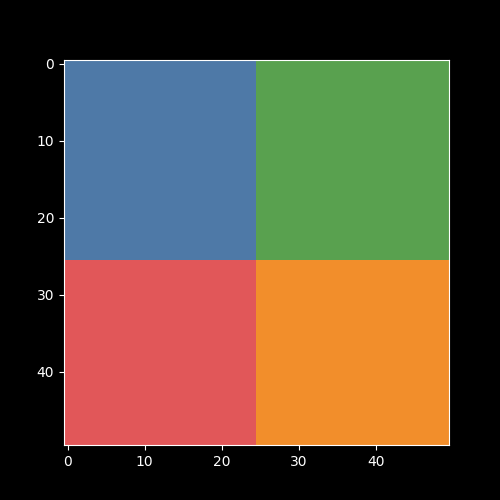

Precio Propiedades  Precio Mudanza
Barrio 0              1.3500            3.00
Barrio 1              1.0125            2.25
Barrio 2              0.5400            1.20
Barrio 3              0.0675            0.15

In [2]:
cuatro_cuadrantes = Mapa.load('./tp/data/mapas/cuatro_cuadrantes.txt', barrios_definidos='./tp/data/mapas/barrios.json')
cuatro_cuadrantes.show()
cuatro_cuadrantes.barrios_info()

Podemos observar que, cómo dijimos antes, el barrio más caro es el rojo, luego el azul, verde y por último el más barato es el naranja.

## Grilla tercios

Por otro lado, tuvimos en cuenta una grilla que está separada por los primeros 3 barrios de forma que se tienen tres tercios del mismo tamaño, dejándo afuera el último barrio (el más barato). 


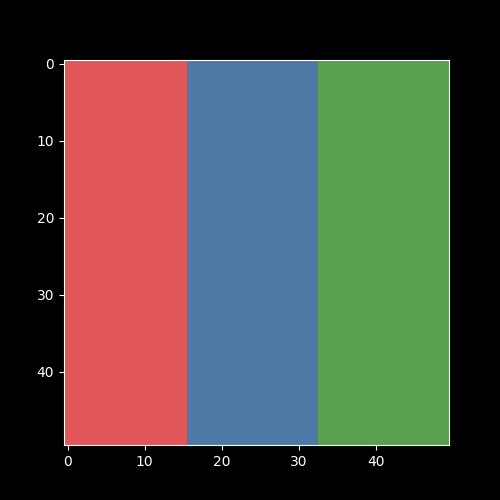

Precio Propiedades  Precio Mudanza
Barrio 0              1.3500            3.00
Barrio 1              1.0125            2.25
Barrio 2              0.5400            1.20

In [3]:
tercios = Mapa.load('./tp/data/mapas/tercios.txt', barrios_definidos='./tp/data/mapas/barrios.json')
tercios.show()
tercios.barrios_info()

## Experimentos

Seteamos una semilla para que todos los experimentos sean reproducibles.

In [4]:
rng = random_number_generator(seed=1)

En esta sección nos centraremos en mostrar la satisfacción de los agentes al variar el rango de visión, además de tener en cuenta distintos $\alpha$, como también dos valores diferentes de capital inicial. Por otro lado, también nos pareció relevante mostrar el Índice de Gini pues nos da una mejor idea de cómo se distribuye el capital inicial bajo distintas condiciones.

### Observaciones Iniciales

Antes de comenzar los experimentos, veamos en detalle una configuración inicial donde se usó una distribución uniforme entre 0 y 10 para asignar el capital inicial. Además, observemos cómo se ve la curva de Lorenz y el Coeficiente de Gini con la configuración inicial elegida.

In [5]:
config_grafica = { # (se puede colapsar)
    # Titulo de ambos graficos
    'suptitle': "Distribución del capital inicial\nmapa: 'cuatro_cuadrantes'",

    # Configuración gráfica del heatmap
    'cmap': 'inferno',

    # Configuración gráfica de Gini/Lorenz
    'color_linea': '#0055FF',
    'color_relleno': '#FF4A00',
    'titulo': 'Curva de Lorenz y Coeficiente de Gini\n\n',
    'subtitulo': 'Comparación entre la igualdad total (gini_index=0, linea de igualdad) y el índice de Gini real, calculado a partir de la distribución de capital inicial de los agentes.',
}

<Figure size 640x480 with 0 Axes>

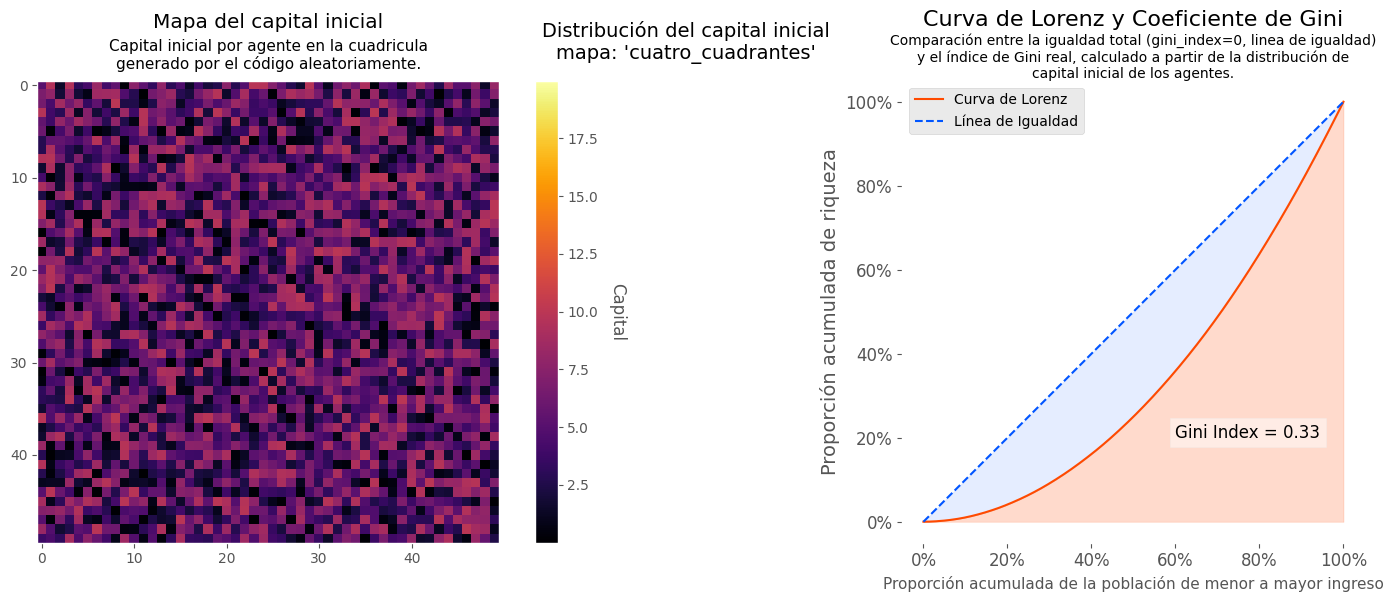

In [6]:
capital_inicial, escala, gini_k0 = \
    generar_capital_inicial(rng.uniform, low=0, high=10, 
                            size=cuatro_cuadrantes.mapa.shape, 
                            config_grafica=config_grafica)

Podemos observar como se ve una distrubución uniforme del capital en el mapa. En la barra de la derecha donde se ve el color dependiendo del capital, se puede ver que esta llega hasta un valor de 20 a pesar de que el capital inicial es hasta 10. Esto se debe a que cuando realicemos los experimentos, habrá agentes que aumenten su capital a más de 10 (ya que aumentan su capital con los intercambios). Pusimos un valor de 20 ya que luego de realizar varias pruebas notamos que como máximo los agentes pueden llegar a duplicar su capital inicial.

Se puede observar que el valor de Gini inicial es al rededor de 0.34. 

Veamos ahora una simulación simple utilizando el mapa cuadrantes, el capital inicial máximo de 10, $\alpha$ = 0.8 y el rango de visión 0.15 para ver cómo varían el porcentaje de satisfechos. Elegimos este rango de visión porque luego veremos que es el rango que más tarda en estabilizarse.

In [7]:
mediciones = (
    mercado_inmobiliario.utilidad_media,
    mercado_inmobiliario.capital_medio,
    gini_total,
    *(gini_barrio_k(x) for x in cuatro_cuadrantes.barrios),  # una medición por barrio
    *(gini_barrio_u(x) for x in cuatro_cuadrantes.barrios),  # una medición por barrio
    *(satisfechos_en(x) for x in cuatro_cuadrantes.barrios), # una medición por barrio
)

parametros_modelo = {
    'alpha': .8,
    'rango_de_vision': 0.15,
}

modelo = mercado_inmobiliario(
    mapa = cuatro_cuadrantes,
    rng = rng,
    capital_inicial=capital_inicial,
    **parametros_modelo
)

sim = simulador(modelo, 
               criterio_equilibrio, 
               max_steps=int(1e3), 
               lag=20, 
               tol=1e-3, 
               cache_actions=mediciones)

In [8]:
satisfechos_inicial = modelo.lattice()
sim.run()
satisfechos_final = modelo.lattice()

/home/joan.new/remote/personal/test/msscae-tp/src/tp/definiciones.py:116: UserWarning: Aplanando la matriz para calcular el coeficiente de Gini.
  warnings.warn("Aplanando la matriz para calcular el coeficiente de Gini.")


La simulación alcanzó el equilibrio en 478 pasos.


In [9]:
opciones_graficas_antes_despues_cuatro_cuadrantes = { # (se puede colapsar)
    'scale': 5,
    'suptitle': "Satisfacción de los agentes - mapa: 'cuatro_cuadrantes'"+'\n'*5,
    'subtitulo': "Calculado a través de la utilidad de cada agente en la cuadrícula.\n" +'Sitios naranjas y amarillos corresponden a agentes insatisfechos' + "\t"*10 + "$t$ indica la cantidad de pasos de la simulación." + "\t"*10 + "; ".join([f'$\\text{{{k}}}={v}$' for k,v in parametros_modelo.items()]),
    'pasos_totales': sim.paso_actual
}

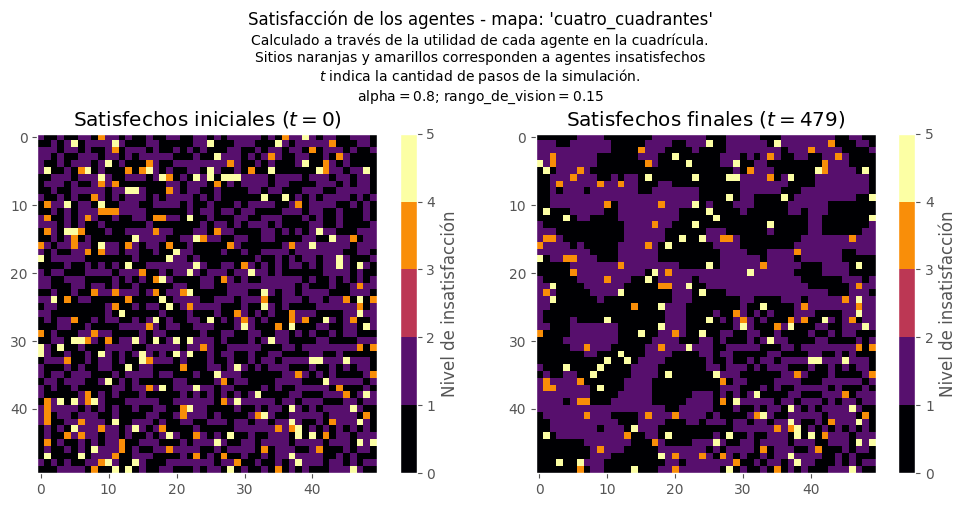

In [10]:
mostrar_satisfechos_antes_despues(satisfechos_inicial, satisfechos_final, 
                                  **opciones_graficas_antes_despues_cuatro_cuadrantes)

Los colores violeta y negro representan los agentes satisfechos de dos clases distintas. Por otro lado, los amarillos y naranjas representan a los insatisfechos. 

Se puede observar como la cantidad de insatisfechos disminuye desde la configuración inicial hasta el final de la simulación. Además, podemos ver cómo se formaron como islas de las distintas clases, ya que cada agente quiere estar cerca de agentes de su misma clase.

Podemos observar con claridad cómo el barrio 3 (que es el de la derecha abajo) tiene a los agentes más dispersos en satisfacción, ya que no vemos la formación de islas del mismo tamaño que sucede en los otros 3 barrios. Esto se debe a que los agentes de este barrio no pareciera que hayan hecho ningún intercambio.

Veamos ahora el índice de Gini final con la curva de Lorenz.

In [11]:
config_grafica = { # (se puede colapsar)
    # Titulo de ambos graficos
    'suptitle': "Distribución del capital final\nmapa: 'cuatro_cuadrantes'",

    # Configuración gráfica del heatmap
    'cmap': 'inferno',
    'subtitle': f'Capital final de los agentes en la cuadrícula luego de {sim.paso_actual} pasos de la simulación.',
    'title': 'Mapa del capital final\n\n',

    # Configuración gráfica de Gini/Lorenz
    'color_linea': '#0055FF',
    'color_relleno': '#FF4A00',
    'titulo': 'Curva de Lorenz y Coeficiente de Gini\n\n',
    'subtitulo': 'Comparación entre la igualdad total (gini_index=0, linea de igualdad) y el índice de Gini real, calculado a partir de la distribución de capital final de los agentes.',
}

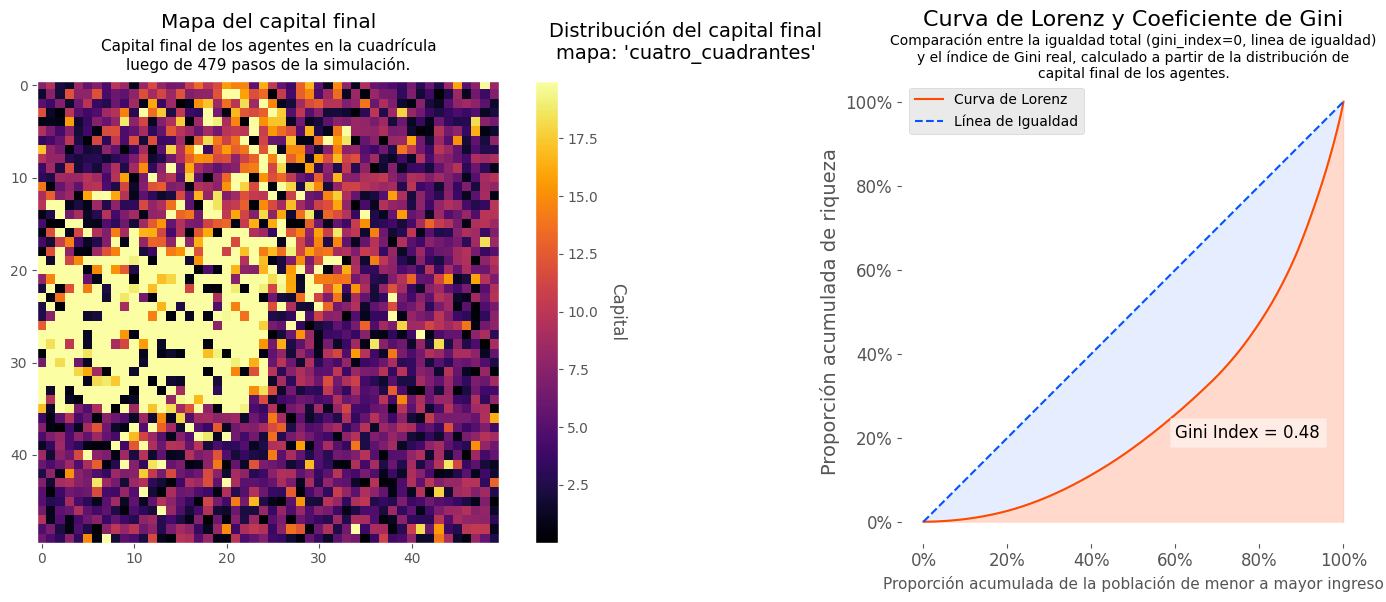

In [12]:
graficar_capital(escala.vmin, escala.vmax, sim.modelo.K, **config_grafica);

Podemos observar que en la distribución de capital final, los agentes con más capital se encuentran distribuidos en los barrios 0 y 1, que son los dos barrios más caros. Por otro lado, en el barrio 2 también vemos algunos agentes con más capital que el máximo inicial (que era 10), pero en el barrio 3, el barrio más barato, no vemos a casi ninguno. Relacionandolo con el gráfico anterior, esto tiene sentido ya que los agentes del barrio 3 habíamos dicho que casi no realizaban ningún intercambio (ya que el porcentaje de satisfechos casi no varíaba). Debido a que el $\alpha$ con el que realizamos esta simulación es 0.8, esto tiene sentido ya que los agentes le dan más importancia al capital.

Además, vemos que el gini final es de 0.48, con lo cual, este aumentó.

### Generación de datos

Antes de realizar los experimentos, debemos generar los datos con los que los haremos. Para ello, realizamos 1000 subdivisiones del rango de visión, es decir, creamos de forma equiespaciada 1000 valores entre 0 y 1. Además, esto lo debemos hacer para los 3 $\alpha$ mencionados anteriormente (0.1, 0.4, 0.8), los dos valores de capital inicial (1, 10), así como también para las dos grillas de barrios (tercios, cuadrantes).


In [13]:
seed = 1

# La cantidad de simulaciones es
# len(alphas) * subdivisiones
# Para probar, se recomienda probar con subdivisiones=10
# Una mejor calidad con no tanto tiempo de simulación se puede obtener con subdivisiones=100
alphas = [.1,.4,.8]
subdivisiones = 1000
# Como referencia, para 
# los mismos alphas y subdivisiones=1000,
# se tardó ~1h con un procesador i5-11260H @ 4GHz & 32 GB RAM
# (por tanda de simulaciones, usando múltiples procesos)

filename_cuatro_cuadrantes_1 = None
filename_cuatro_cuadrantes_10 = None
filename_tercios_1 = None
filename_tercios_10 = None

En las siguientes celdas se simulan los modelos, iterando sobre el rango de visión según las subdivisiones seleccionadas.
Hay _hardcodeadas_ 4 tandas de simulaciones. En orden:
- cuatro_cuadrantes, start_max=10
- cuatro_cuadrantes, start_max=1
- tercios, start_max=10
- tercios, start_max=1

Luego de simularse, los datos se guardan automáticamente, y los nombres de archivos definidos anteriormente
son pisados con los nombres elegidos automáticamente según los parámetros de la simulación.
Esos nombres luego van a ser usados para cargar los datos que se acaban de generar.

Si más abajo se sobreescriben los nombres de los archivos, es posible graficar datos previamente guardados, sin
necesidad de generar nuevos.


---
**Si no se aprietan los botones para correr las simulaciones, la celda siguiente donde se guardan los datos
va a fallar porque no hay nada en el contenedor.**

---

In [14]:
start_max = 1 # (hardcodeado)
inputs_1 = generar_inputs(alphas, subdivisiones, seed, start_max, 'uniform', './tp/data/mapas/barrios.json', './tp/data/mapas/cuatro_cuadrantes.txt')

storage = MutableStorage()
create_os_buttons(detect_os(), opciones_ejecutar_modelo(inputs_1, storage))

# Si no andan los botones, se puede ejecutar manualmente:

# simuladores.set_store(correr_secuencialmente(inputs_1)) # correr con un solo hilo
# simuladores.set_store(correr_en_paralelo(inputs_1)) # correr en paralelo

**Correr en paralelo (con multiprocesos) sólo en Linux. En Windows los procesos se rompen.**

  0%|          | 0/3 [00:00<?, ?it/s]

In [15]:
try: # (se puede colapsar)
    simuladores: list = storage.get_store()
    resultados = [
    s.export(
        observaciones = observaciones_de,
        alpha = alpha_del_modelo,
        rango = rango_del_modelo,
        gini_tk = gini_capital_modelo,
        gini_tu = gini_utilidad_modelo,
        ginis_k = gini_capital_por_barrio,
        ginis_u = gini_utilidad_por_barrio,
        satisfechos = satisfechos_por_barrio,
        pasos = cantidad_de_pasos)
    
    for s in simuladores
    ]

    filename_cuatro_cuadrantes_1 = generate_filename('cuatro_cuadrantes', start_max, alphas, subdivisiones, seed)
    filename_cuatro_cuadrantes_1 = non_colliding_name(filename_cuatro_cuadrantes_1)
    json.dump(resultados, filename_cuatro_cuadrantes_1)

    del storage
    del resultados
    simuladores.clear()
    del simuladores
except AttributeError:
    if isinstance(simuladores, list):
        pass

In [16]:
start_max = 10 # (hardcodeado)
inputs_2 = generar_inputs(alphas, subdivisiones, seed, start_max, 'uniform', './tp/data/mapas/barrios.json', './tp/data/mapas/cuatro_cuadrantes.txt')
storage = MutableStorage()
create_os_buttons(detect_os(), opciones_ejecutar_modelo(inputs_2, storage))

# Si no andan los botones, se puede ejecutar manualmente:

# simuladores.set_store(correr_secuencialmente(inputs_2)) # correr con un solo hilo
# simuladores.set_store(correr_en_paralelo(inputs_2)) # correr en paralelo

**Correr en paralelo (con multiprocesos) sólo en Linux. En Windows los procesos se rompen.**

  0%|          | 0/3 [00:00<?, ?it/s]

In [17]:
try: # (se puede colapsar)
    simuladores: list = storage.get_store()
    resultados = [
    s.export(
        observaciones = observaciones_de,
        alpha = alpha_del_modelo,
        rango = rango_del_modelo,
        gini_tk = gini_capital_modelo,
        gini_tu = gini_utilidad_modelo,
        ginis_k = gini_capital_por_barrio,
        ginis_u = gini_utilidad_por_barrio,
        satisfechos = satisfechos_por_barrio,
        pasos = cantidad_de_pasos)
    
    for s in simuladores
    ]

    filename_cuatro_cuadrantes_10 = generate_filename('cuatro_cuadrantes', start_max, alphas, subdivisiones, seed)
    filename_cuatro_cuadrantes_10 = non_colliding_name(filename_cuatro_cuadrantes_10)
    json.dump(resultados, filename_cuatro_cuadrantes_10)

    del storage
    del resultados
    simuladores.clear()
    del simuladores
except AttributeError:
    if isinstance(simuladores, list):
        pass

In [18]:
start_max = 1 # (hardcodeado)
inputs_3 = generar_inputs(alphas, subdivisiones, seed, start_max, 'uniform', './tp/data/mapas/barrios.json', './tp/data/mapas/tercios.txt')
storage = MutableStorage()
create_os_buttons(detect_os(), opciones_ejecutar_modelo(inputs_3, storage))

# Si no andan los botones, se puede ejecutar manualmente:

# simuladores.set_store(correr_secuencialmente(inputs_3)) # correr con un solo hilo
# simuladores.set_store(correr_en_paralelo(inputs_3)) # correr en paralelo

**Correr en paralelo (con multiprocesos) sólo en Linux. En Windows los procesos se rompen.**

  0%|          | 0/3 [00:00<?, ?it/s]

In [19]:
try: # (se puede colapsar)
    simuladores: list = storage.get_store()
    resultados = [
    s.export(
        observaciones = observaciones_de,
        alpha = alpha_del_modelo,
        rango = rango_del_modelo,
        gini_tk = gini_capital_modelo,
        gini_tu = gini_utilidad_modelo,
        ginis_k = gini_capital_por_barrio,
        ginis_u = gini_utilidad_por_barrio,
        satisfechos = satisfechos_por_barrio,
        pasos = cantidad_de_pasos)
    
    for s in simuladores
    ]

    filename_tercios_1 = generate_filename('tercios', start_max, alphas, subdivisiones, seed)
    filename_tercios_1 = non_colliding_name(filename_tercios_1)
    json.dump(resultados, filename_tercios_1)

    del storage
    del resultados
    simuladores.clear()
    del simuladores
except AttributeError:
    if isinstance(simuladores, list):
        pass

In [20]:
start_max = 10 # (hardcodeado)
inputs_4 = generar_inputs(alphas, subdivisiones, seed, start_max, 'uniform', './tp/data/mapas/barrios.json', './tp/data/mapas/tercios.txt')
storage = MutableStorage()
create_os_buttons(detect_os(), opciones_ejecutar_modelo(inputs_4, storage))

# Si no andan los botones, se puede ejecutar manualmente:

# simuladores.set_store(correr_secuencialmente(inputs_4)) # correr con un solo hilo
# simuladores.set_store(correr_en_paralelo(inputs_4)) # correr en paralelo

**Correr en paralelo (con multiprocesos) sólo en Linux. En Windows los procesos se rompen.**

  0%|          | 0/3 [00:00<?, ?it/s]

In [21]:
try: # (se puede colapsar)
    simuladores: list = storage.get_store()
    resultados = [
    s.export(
        observaciones = observaciones_de,
        alpha = alpha_del_modelo,
        rango = rango_del_modelo,
        gini_tk = gini_capital_modelo,
        gini_tu = gini_utilidad_modelo,
        ginis_k = gini_capital_por_barrio,
        ginis_u = gini_utilidad_por_barrio,
        satisfechos = satisfechos_por_barrio,
        pasos = cantidad_de_pasos)
    
    for s in simuladores
    ]

    filename_tercios_10 = generate_filename('tercios', start_max, alphas, subdivisiones, seed)
    filename_tercios_10 = non_colliding_name(filename_tercios_10)
    json.dump(resultados, filename_tercios_10)

    del storage
    del resultados
    simuladores.clear()
    del simuladores
except AttributeError:
    if isinstance(simuladores, list):
        pass

In [22]:
# Para usar datos viejos, cargar acá los archivos. (esta celda se puede colapsar)

# filename_cuatro_cuadrantes_10 = './tp/data/resultados/cuatro_cuadrantes_10.0_841_1000_1.json'
# filename_cuatro_cuadrantes_1 = './tp/data/resultados/cuatro_cuadrantes_1.0_841_1000_1.json'
# filename_tercios_10 = './tp/data/resultados/tercios_10_841_1000_1.json'
# filename_tercios_1 = './tp/data/resultados/tercios_1.0_841_1000_1.json'

In [23]:
resultados_1 = json.load(filename_cuatro_cuadrantes_10)
resultados_2 = json.load(filename_cuatro_cuadrantes_1)
resultados_3 = json.load(filename_tercios_10)
resultados_4 = json.load(filename_tercios_1)

### Satisfacción
Nuestro objetivo principal del trabajo era ver cómo variaba la cantidad de satisfechos en el estado de equilibrio (si existe), en función de distintos rangos de visión. Además, consideramos diversos costos de mudanza y costos de propiedad según el barrio. 

Para responder esta pregunta, nos pareció adecuado separar los estudios basándonos en ambas grillas de barrios, la de cuadrantes y la de tercios.

In [24]:
def extraer_satisfechos(resultados: dict) -> dict:
    satisfechos = dict()

    for r in resultados:
        alpha = r['alpha']
        rango = r['rango']
        satisfechos_totales = r['satisfechos']

        satisfechos.setdefault(alpha, {}).setdefault(rango, sum(satisfechos_totales))
    
    return satisfechos

In [25]:
satisfechos_1 = extraer_satisfechos(resultados_1)
satisfechos_2 = extraer_satisfechos(resultados_2)
satisfechos_3 = extraer_satisfechos(resultados_3)
satisfechos_4 = extraer_satisfechos(resultados_4)

In [26]:
N = 50*50

Para los siguientes gráficos hicimos simulaciones para 1000 rangos de visión entre 0 y 1, y nos guardamos los satisfechos totales al llegar al equilibrio o al llegar a la cantidad máxima de pasos (150). 

Como lo que nos interesa es ver la tendencia de los satisfechos para los rangos de visión por $\alpha$, lo que hicimos fue aplicar el filtro Savitzky-Golay sobre los datos crudos de las mediciones para suavizar la medición. En los gráficos podemos ver tanto los datos crudos (raw) como la tendencia.

#### Tercios

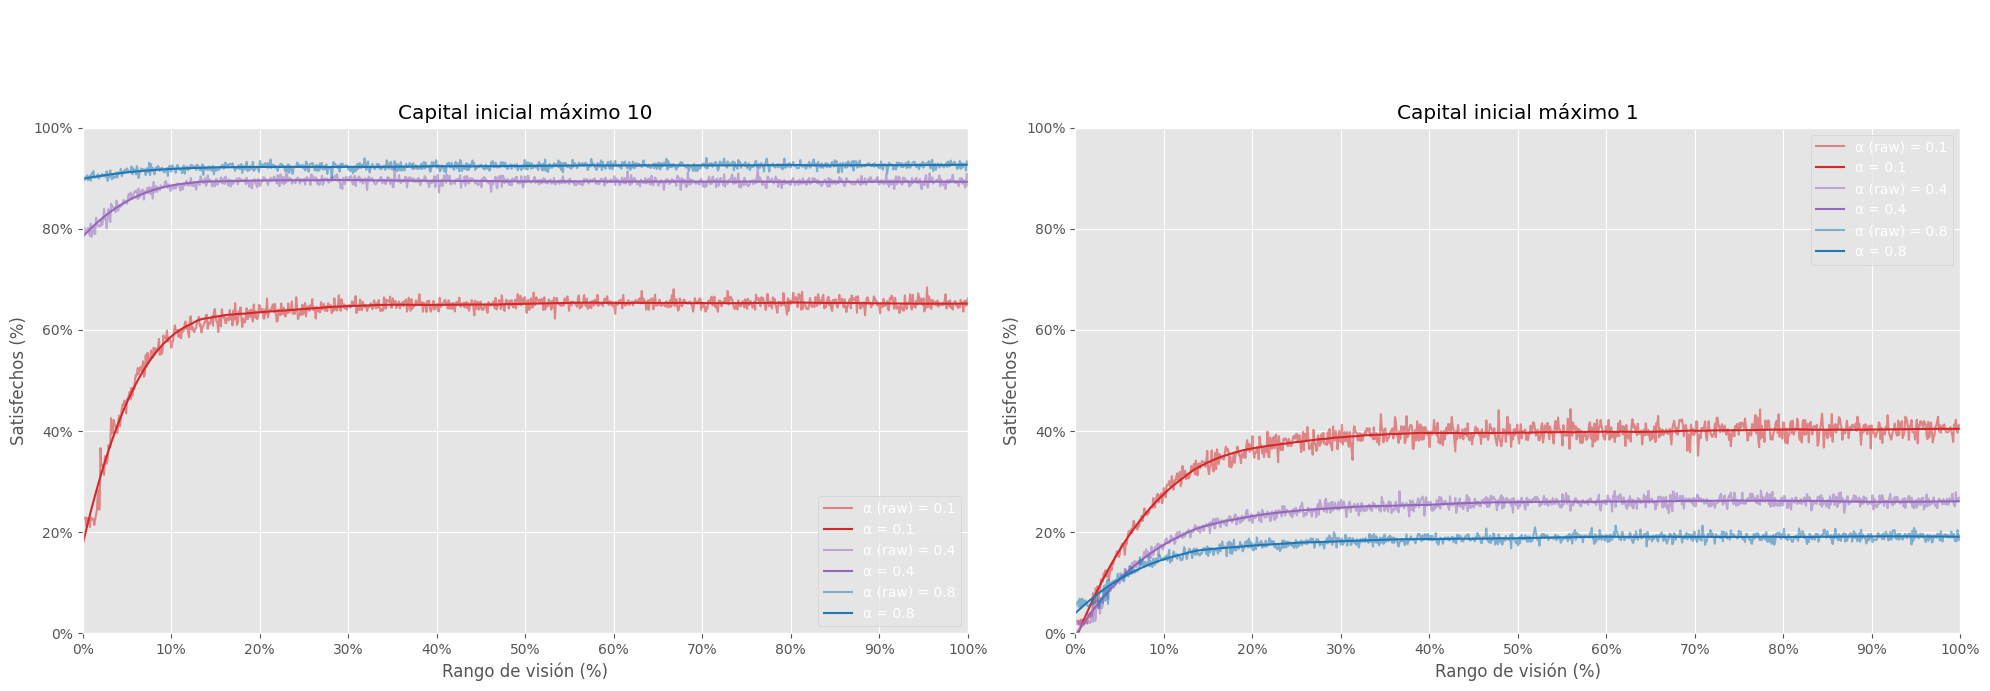

In [27]:
# (esta celda se puede colapsar, simplemente se grafican los datos)
df1 = pd.DataFrame(satisfechos_3)
df2 = pd.DataFrame(satisfechos_4)

colors = {
    0.1: 'tab:red',
    0.4: 'tab:purple',
    0.8: 'tab:blue'
}

fig, axes = plt.subplots(1, 2, figsize=(20, 7))  

fig.suptitle('Satisfechos totales por rango de visión para mapa Tercios', fontsize=16)

plt.figtext(0.5, 0.85, 'Resultado de medir la cantidad de satisfechos al final de las simulaciones para \n 1000 rangos de visión entre 0 y 1 (eje x)', ha='center', fontsize=12)

def percentage(x, pos):
    return f'{x:.0f}%'

for ax in axes:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(percentage))

axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 100)
axes[0].set_title('Capital inicial máximo 10', color='black')  # Customize as needed
axes[0].set_xlabel('Rango de visión (%)')
axes[0].set_ylabel('Satisfechos (%)')
axes[0].set_xticks([i/10 for i in range(11)])
axes[0].set_xticklabels([f'{i*10}%' for i in range(11)])

for alpha in df1.columns:
    axes[0].plot(df1.index, 100 * df1[alpha] / N, alpha=0.5, color=colors[alpha], label=f'α (raw) = {alpha}')
    axes[0].plot(df1.index, 100 * smooth_data(df1[alpha]) / N, alpha=1, color=colors[alpha], label=f'α = {alpha}')

axes[0].legend(loc='lower right')

# Second plot
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 100)
axes[1].set_title('Capital inicial máximo 1', color='black')  # Customize as needed
axes[1].set_xlabel('Rango de visión (%)')
axes[1].set_ylabel('Satisfechos (%)')
axes[1].set_xticks([i/10 for i in range(11)])
axes[1].set_xticklabels([f'{i*10}%' for i in range(11)])

for alpha in df2.columns:
    axes[1].plot(df2.index, 100 * df2[alpha] / N, alpha=0.5, color=colors[alpha], label=f'α (raw) = {alpha}')
    axes[1].plot(df2.index, 100 * smooth_data(df2[alpha]) / N, alpha=1, color=colors[alpha], label=f'α = {alpha}')

axes[1].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to make room for the subtitle
plt.show()

Observamos que a medida que aumenta el rango de visión, en ambos gráficos para el $\alpha$ = 0.1 se observa un crecimiento pronunciado de satisfechos, para luego estabilizarse. Sin embargo, a medida que aumenta el $\alpha$, este crecimiento es cada vez más pequeño. 

En el gráfico de capital inicial máximo 10, se tiene más riqueza para distribuir. Al valorarse más la riqueza, es decir, cuando el $\alpha$ crece, tiene sentido que el porcentaje de satisfechos sea mayor en comparación al gráfico de capital inicial máximo 1.


#### Cuadrantes

Hagamos lo mismo para el mapa de cuadrantes.

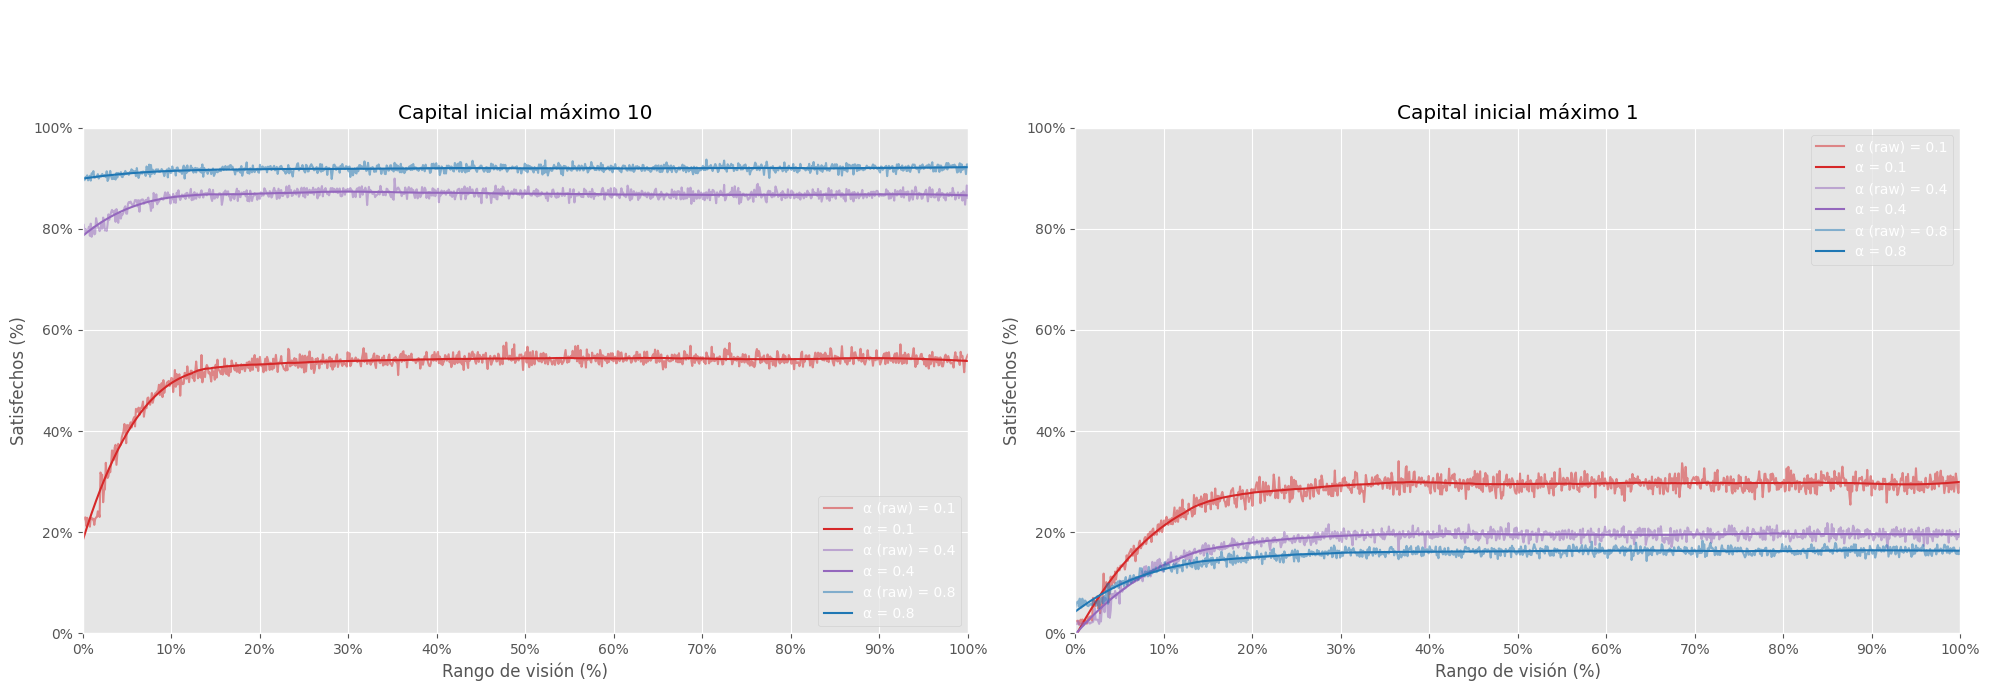

In [28]:
# (esta celda se puede colapsar, simplemente se grafican los datos)
df1 = pd.DataFrame(satisfechos_1)
df2 = pd.DataFrame(satisfechos_2)

colors = {
    0.1: 'tab:red',
    0.4: 'tab:purple',
    0.8: 'tab:blue'
}

fig, axes = plt.subplots(1, 2, figsize=(20, 7))  

fig.suptitle('Satisfechos totales por rango de visión para mapa Cuadrantes', fontsize=16)

plt.figtext(0.5, 0.85, 'Resultado de medir la cantidad de satisfechos al final de las simulaciones para \n 1000 rangos de visión entre 0 y 1 (eje x)', ha='center', fontsize=12)

def percentage(x, pos):
    return f'{x:.0f}%'

for ax in axes:
    ax.yaxis.set_major_formatter(plt.FuncFormatter(percentage))

axes[0].set_xlim(0, 1)
axes[0].set_ylim(0, 100)
axes[0].set_title('Capital inicial máximo 10', color='black')  # Customize as needed
axes[0].set_xlabel('Rango de visión (%)')
axes[0].set_ylabel('Satisfechos (%)')
axes[0].set_xticks([i/10 for i in range(11)])
axes[0].set_xticklabels([f'{i*10}%' for i in range(11)])

for alpha in df1.columns:
    axes[0].plot(df1.index, 100 * df1[alpha] / N, alpha=0.5, color=colors[alpha], label=f'α (raw) = {alpha}')
    axes[0].plot(df1.index, 100 * smooth_data(df1[alpha]) / N, alpha=1, color=colors[alpha], label=f'α = {alpha}')

axes[0].legend(loc='lower right')

# Second plot
axes[1].set_xlim(0, 1)
axes[1].set_ylim(0, 100)
axes[1].set_title('Capital inicial máximo 1', color='black')  # Customize as needed
axes[1].set_xlabel('Rango de visión (%)')
axes[1].set_ylabel('Satisfechos (%)')
axes[1].set_xticks([i/10 for i in range(11)])
axes[1].set_xticklabels([f'{i*10}%' for i in range(11)])

for alpha in df2.columns:
    axes[1].plot(df2.index, 100 * df2[alpha] / N, alpha=0.5, color=colors[alpha], label=f'α (raw) = {alpha}')
    axes[1].plot(df2.index, 100 * smooth_data(df2[alpha]) / N, alpha=1, color=colors[alpha], label=f'α = {alpha}')

axes[1].legend(loc='upper right')

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Adjust layout to make room for the subtitle
plt.show()


Vemos que la comparación para la grilla de cuadrantes es muy similar a la de tercios, pero el rango de visión en el que se estabiliza la curva de $\alpha$ = 0.1 es menor (aprox. 10%) en el caso de capital inicial máximo 10. En cambio, para capital inicial máximo 1, todas las curvas se estabilizan en un máximo de satisfechos menor.

### Satisfacción por barrio
Nos pareció interesante estudiar la satisfacción por barrio para un caso particular. Elegimos la grilla de cuatro cuadrantes y capital inicial máximo 10. Veamos entonces cómo varía la satisfacción por barrio para los 3 valores de $\alpha$ elegidos.

In [29]:
habitantes_por_barrio_cuad = [
    (cuatro_cuadrantes.mapa == i).sum()
    for i in range(4)
]

In [30]:
def satisfaccion(resultados):
    satisfaccion_t = dict()

    for cache in resultados:
        alpha = cache['alpha']
        rango = cache['rango']

        for s in cache['satisfechos']:
            satisfaccion_t.setdefault(alpha, {}).setdefault(rango, []).append(s)

    return satisfaccion_t

In [31]:
# Esta celda es sólo para la presentación. Requiere plotly. Se puede comentar y colapsar
from tp.presentacion import graficar_satisfechos_por_alpha_cuatro_cuadrantes_plotly
graficar_satisfechos_por_alpha_cuatro_cuadrantes_plotly(resultados_1, cuatro_cuadrantes, habitantes_por_barrio_cuad)

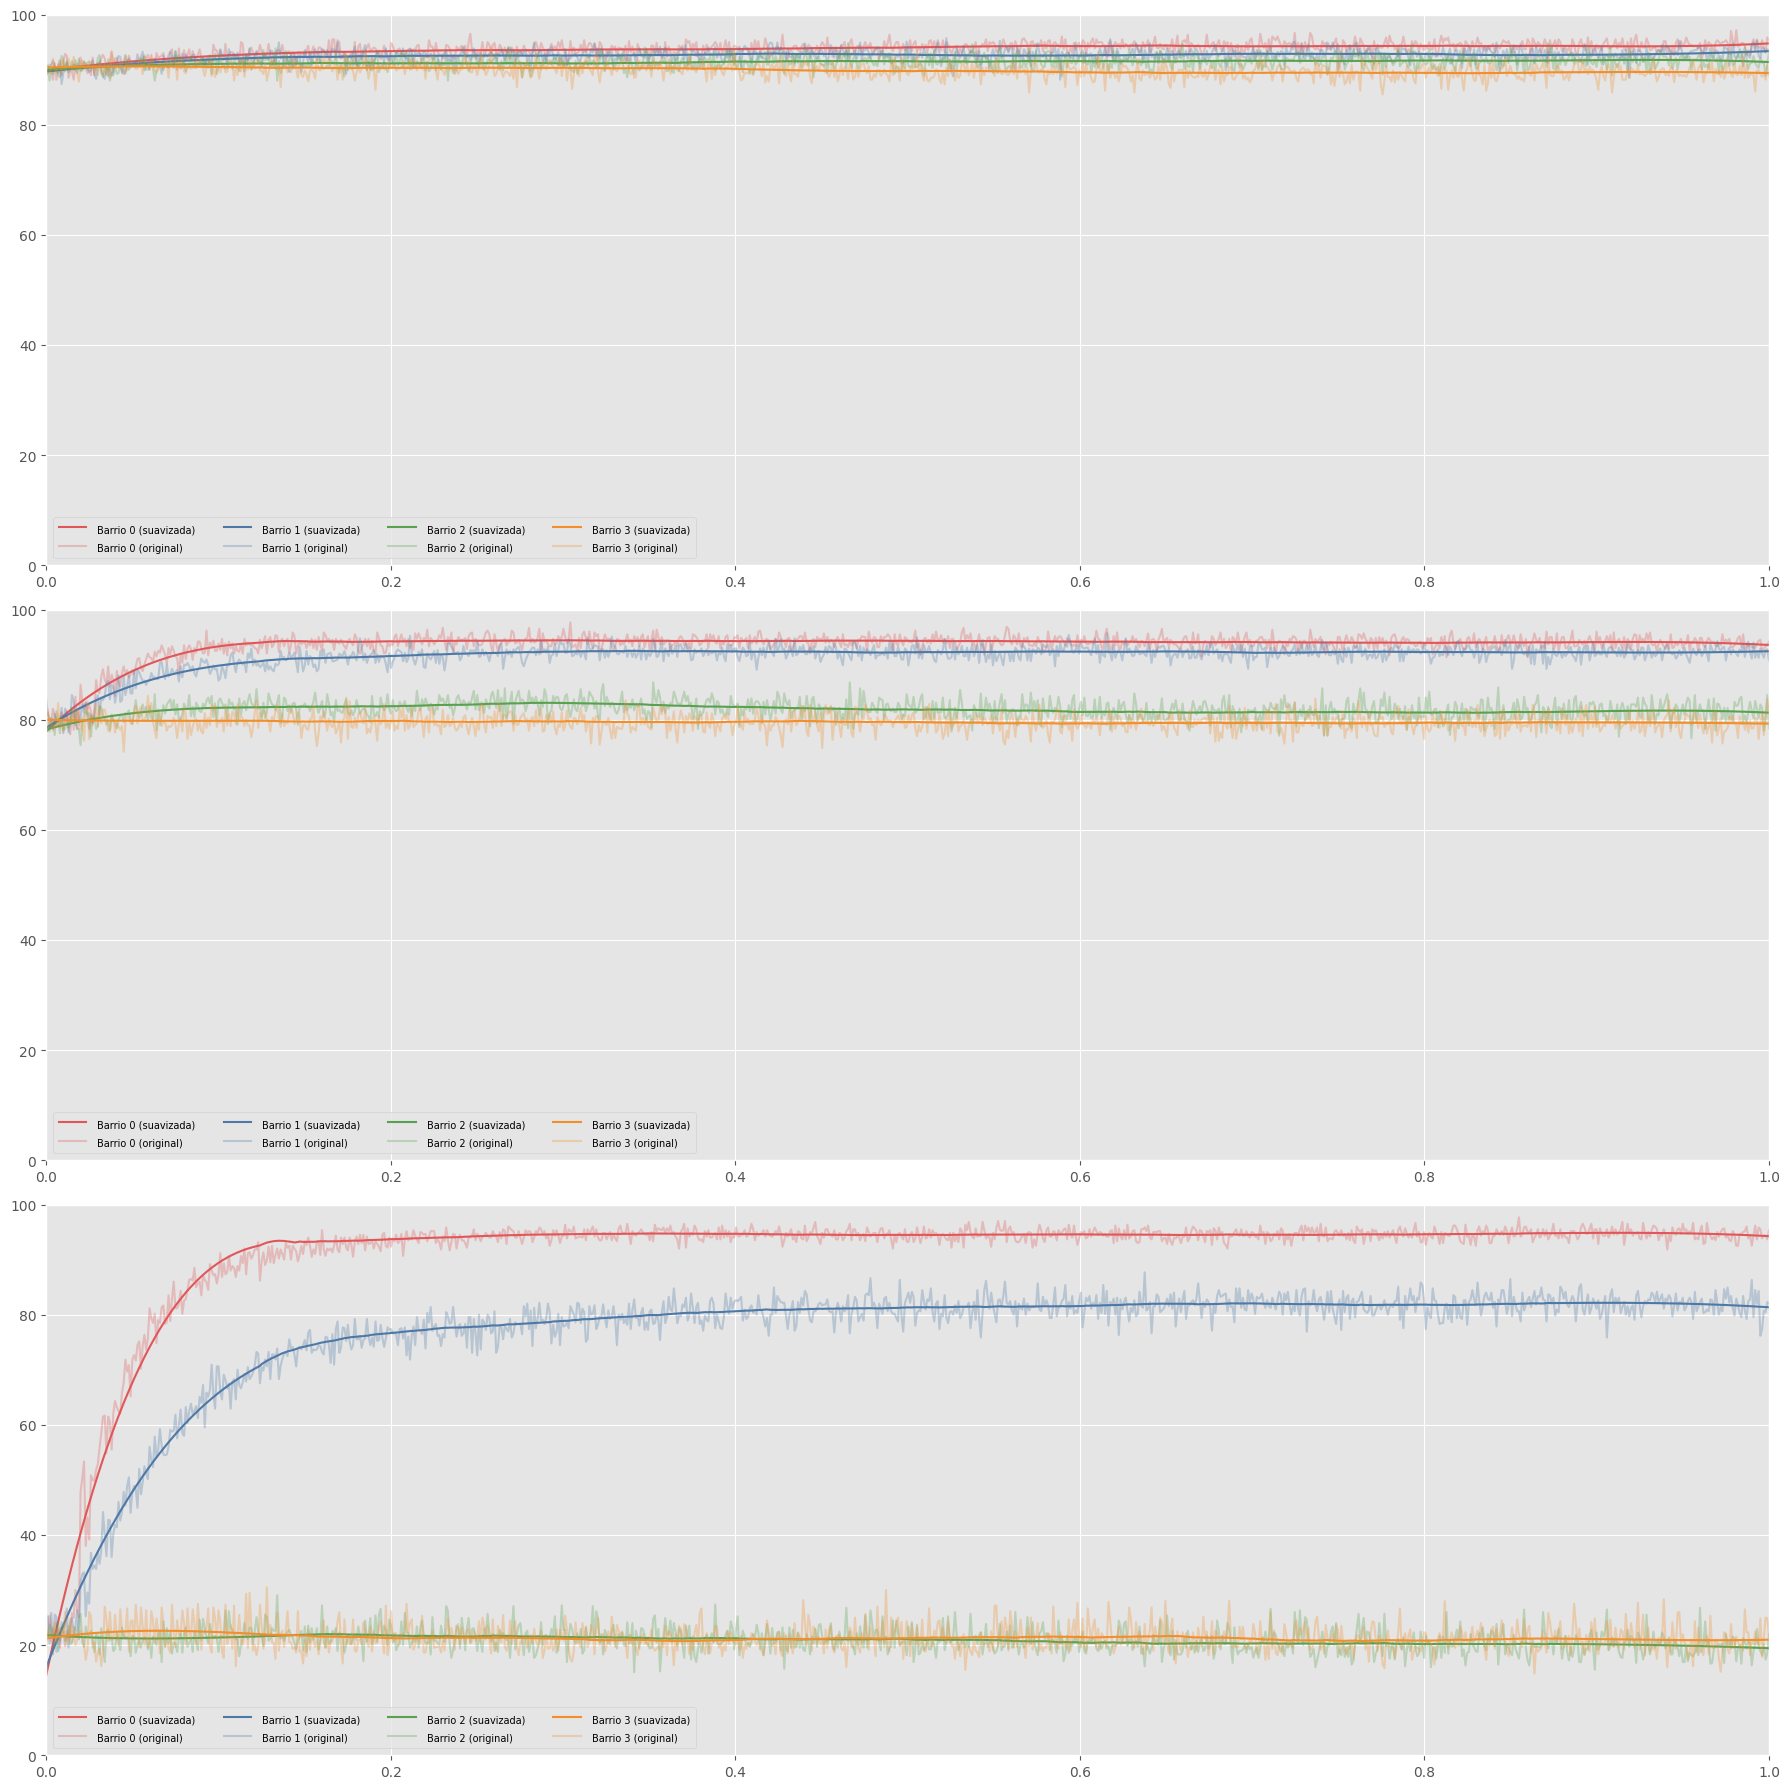

In [32]:
fig, axs = plt.subplots(3, 1, figsize=(18, 18))  
sat = satisfaccion(resultados_1)

plot_satisfacciones_para_alpha(.8, sat, habitantes_por_barrio_cuad, cuatro_cuadrantes.barrios_definidos, ax=axs[0])
plot_satisfacciones_para_alpha(.4, sat, habitantes_por_barrio_cuad, cuatro_cuadrantes.barrios_definidos, ax=axs[1])
plot_satisfacciones_para_alpha(.1, sat, habitantes_por_barrio_cuad, cuatro_cuadrantes.barrios_definidos, ax=axs[2])

plt.tight_layout()
plt.show()

Recordemos que si el $\alpha$ es:
* bajo: importa más el valor de la casa
* medio: importan por igual
* alto: importa más la riqueza
Un $\alpha$ grande significa que se prioriza más el capital.

En el primer caso, de $\alpha$ = 0.8, estamos poniendo un límite de capital muy alto y todos los agentes priorizan mucho la riqueza. Podemos notar que en todos los barrios el porcentaje de satisfechos finales se encuentra entre 85% y 95% para todos los rangos de visión considerados. 

En el segundo gráfico, tomamos un valor de $\alpha$ medio, 0.4. Por lo tanto, los agentes priorizan el capital y el valor de la casa casi de la misma forma (aunque priorizan un poquito más el valor de la casa). Podemos notar que para el rango de visión 0 (i.e. sin intercambios), todos los barrios comienzan con un porcentaje de satisfechos finales que ronda el 80%. Sin embargo, a medida que aumenta el rango de visión, se genera una leve diferencia entre los barrios 0 y 1 (barrios más caros), con los barrios 2 y 3 (barrios más baratos) en donde los primeros tienen un porcentaje de satisfechos mayor. 

Por último, en el gráfico de $\alpha$ = 0.1, notamos que se profundiza la diferencia entre los barrios más caros y los más baratos. Los barrios más baratos son los que tienen menor porcentaje de satisfechos. Esto es consecuencia de que como el $\alpha$ es bajo nos importa más el valor de la casa, por lo tanto los agentes estarán dispuestos a comprar casas más caras, que son las que se encuentran en los barrios 0 y 1.

### Índice de Gini

Debido a que vimos que hay tanta diferencia de porcentaje de satisfechos entre barrios para $\alpha$ bajo, nos pareció interesante analizar la desigualdad entre riquezas de los agentes. Para esto, nos pareció conveniente utilizar el índice de Gini. El coeficiente de Gini es un número entre 0 y 1, donde 0 se corresponde con la total igualdad (todos tienen la misma riqueza) y 1 se corresponde con la desigualdad absoluta (una persona tiene toda la riqueza y los demás no tienen nada).

Para este experimento, nos pareció adecuado realizar la experimentación separando en función del capital inicial máximo. Inicialmente, para un capital inicial máximo 1 y luego para uno de 10, realizando en cada caso los gráficos para las dos grillas de barrios que hay.

In [33]:
def extraer_gini(resultados: dict) -> dict:
    ginis_tk = dict()

    for r in resultados:
        alpha = r['alpha']
        rango = r['rango']
        gini_tk = r['gini_tk']

        ginis_tk.setdefault(alpha, {}).setdefault(rango, gini_tk)
    
    return ginis_tk

#### Capital Inicial Máximo 1

Comenzamos analizando el índice de Gini para los casos en el que se empieza con un capital máximo de 1.

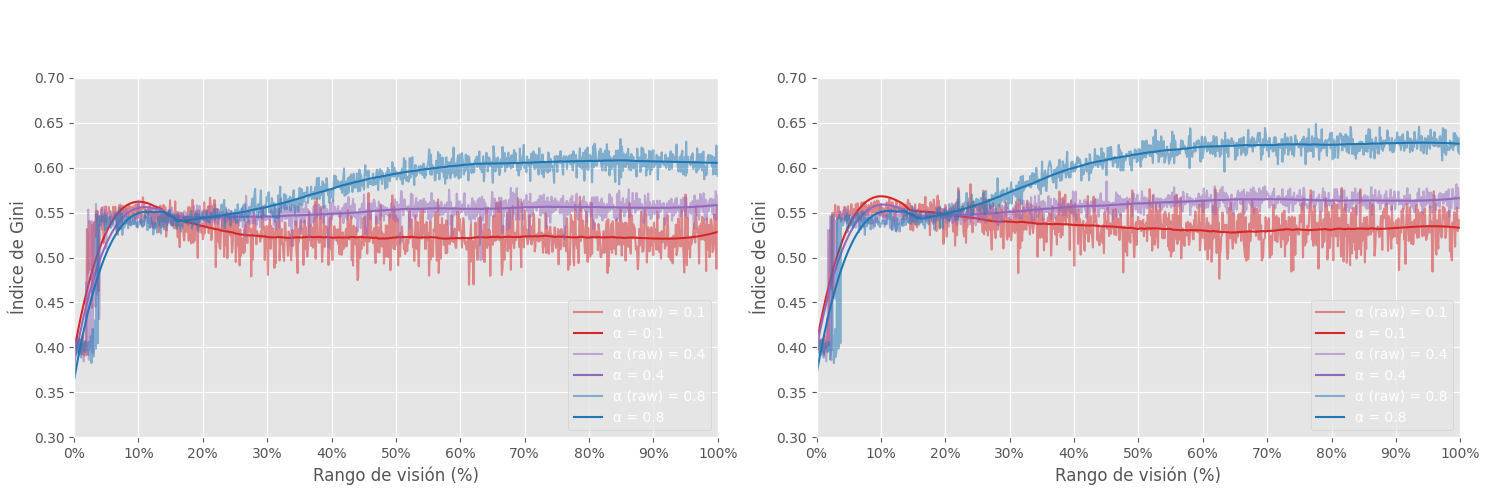

In [34]:
# (esta celda se puede colapsar, simplemente se grafican los datos)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Una fila, dos columnas, tamaño de la figura

# Gráfico 1: Cuadrantes
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0.3, 0.7)

df_2 = pd.DataFrame(extraer_gini(resultados_2))
for alpha in df_2.columns:
    axs[0].plot(df_2.index, df_2[alpha], label=f'α (raw) = {alpha}', color=colors[alpha], alpha=0.5)
    axs[0].plot(df_2.index, smooth_data(df_2[alpha]), label=f'α = {alpha}', color=colors[alpha])

axs[0].set_title('Índice de Gini para el mapa Cuadrantes')
axs[0].legend()
axs[0].set_xlabel('Rango de visión (%)')
axs[0].set_ylabel('Índice de Gini')
axs[0].set_xticks([i/10 for i in range(11)])
axs[0].set_xticklabels([f'{i*10}%' for i in range(11)])
fig.suptitle('Comparación de los índices de Gini para diferentes mapas con capital inicial máximo 1', fontsize=16)

# Gráfico 2: Tercios
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0.3, 0.7)

df_4 = pd.DataFrame(extraer_gini(resultados_4))
for alpha in df_4.columns:
    axs[1].plot(df_4.index, df_4[alpha], label=f'α (raw) = {alpha}', color=colors[alpha], alpha=0.5)
    axs[1].plot(df_4.index, smooth_data(df_4[alpha]), label=f'α = {alpha}', color=colors[alpha])

axs[1].set_title('Índice de Gini para el mapa Tercios')
axs[1].legend()
axs[1].set_xlabel('Rango de visión (%)')
axs[1].set_ylabel('Índice de Gini')
axs[1].set_xticks([i/10 for i in range(11)])
axs[1].set_xticklabels([f'{i*10}%' for i in range(11)])

plt.tight_layout()  # Ajustar el espacio entre los gráficos
plt.show()


Vemos que en ambos gráficos en los rangos de visión iniciales aumenta considerablemente el índice de Gini. 

A medida que aumenta el $\alpha$, aumenta el índice de Gini, lo cual nos dice que hay más desigualdad de capital en la población. Sin embargo, a medida que al aumenta el rango de visión todos se estabilizan al llegar a un valor de aproximadamente 50%. 

#### Capital Inicial Máximo 10

Ahora hacemos lo mismo pero para cuando comenzamos con un capital máximo de 10.

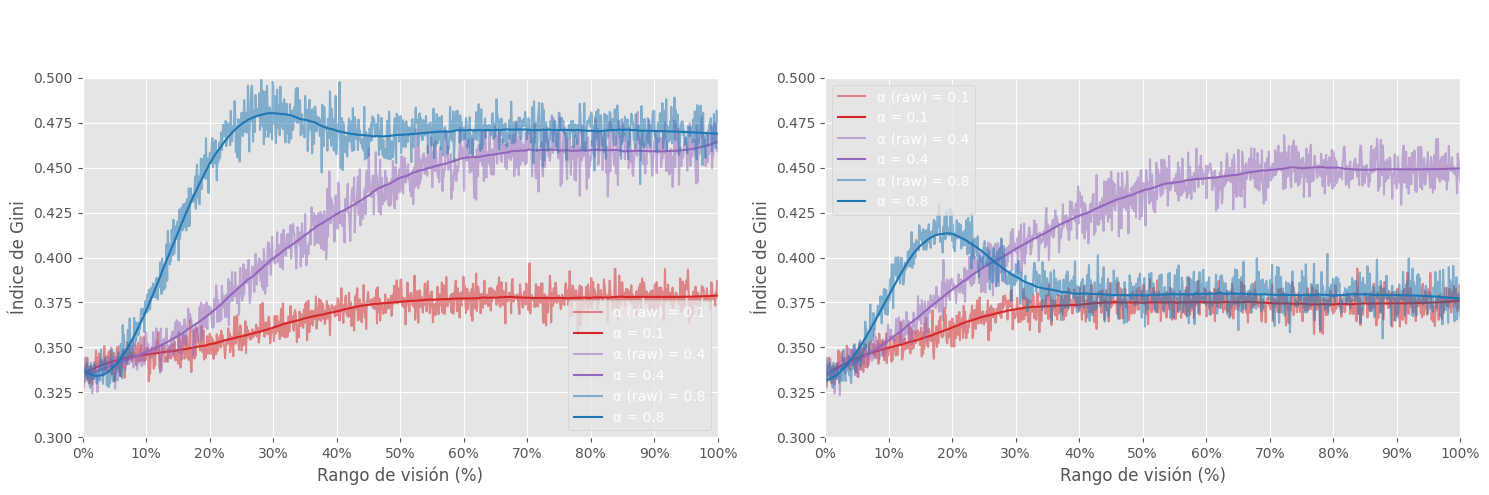

In [35]:
# (esta celda se puede colapsar, simplemente se grafican los datos)
fig, axs = plt.subplots(1, 2, figsize=(15, 5))  # Una fila, dos columnas, tamaño de la figura

# Gráfico 1: Cuadrantes
axs[0].set_xlim(0, 1)
axs[0].set_ylim(0.3, 0.5)

df_1 = pd.DataFrame(extraer_gini(resultados_1))
for alpha in df_1.columns:
    axs[0].plot(df_1.index, df_1[alpha], label=f'α (raw) = {alpha}', color=colors[alpha], alpha=0.5)
    axs[0].plot(df_1.index, smooth_data(df_1[alpha]), label=f'α = {alpha}', color=colors[alpha])

axs[0].set_title('Índice de Gini para el mapa Cuadrantes')
axs[0].legend()
axs[0].set_xlabel('Rango de visión (%)')
axs[0].set_ylabel('Índice de Gini')
axs[0].set_xticks([i/10 for i in range(11)])
axs[0].set_xticklabels([f'{i*10}%' for i in range(11)])
fig.suptitle('Comparación de los índices de Gini para diferentes mapas con capital inicial máximo 10', fontsize=16)

# Gráfico 2: Tercios
axs[1].set_xlim(0, 1)
axs[1].set_ylim(0.3, 0.5)

df_3 = pd.DataFrame(extraer_gini(resultados_3))
for alpha in df_3.columns:
    axs[1].plot(df_3.index, df_3[alpha], label=f'α (raw) = {alpha}', color=colors[alpha], alpha=0.5)
    axs[1].plot(df_3.index, smooth_data(df_3[alpha]), label=f'α = {alpha}', color=colors[alpha])

axs[1].set_title('Índice de Gini para el mapa Tercios')
axs[1].legend()
axs[1].set_xlabel('Rango de visión (%)')
axs[1].set_ylabel('Índice de Gini')
axs[1].set_xticks([i/10 for i in range(11)])
axs[1].set_xticklabels([f'{i*10}%' for i in range(11)])

plt.tight_layout()  # Ajustar el espacio entre los gráficos
plt.show()

Podemos observar que en ambos gráficos a medida que aumenta el rango de visión, el índice de Gini aumenta rápidamente para todos los $\alpha$ hasta que se estabiliza. Para el $\alpha$ = 0.8 el aumento de Gini es mucho más pronunciado al comienzo en ambos gráficos, en comparación con los otros dos $\alpha$. 

Por otro lado, al comparar ambos gráficos vemos que la configuración inicial de barrios es importante al momento de estudiar el efecto que tiene el cambio de $\alpha$ en el índice de Gini. Para los $\alpha$ más grandes, en nuestro caso $\alpha$ = 0.8, se ve que en el mapa de tercios la tendencia llega a un punto máximo de Gini y luego disminuye mucho más que en el mapa de cuartos, ya que en este último el índice de Gini supera al de $\alpha$ = 0.4, mientras que en el mapa de tercios el de $\alpha$ = 0.4 es mayor al momento de estabilizarse.


## Conclusiones

Luego de realizar los experimentos del trabajo, podemos concluir que, cuando el rango de visión se encuentra entre 0 y 0.2, a medida que lo aumentamos, la cantidad de satisfechos también lo hace hasta llegar a un máximo, sin importar el $\alpha$, grilla o máximo capital con el que se esté trabajando.
A partir de un rango de visión de aproximadamente 0.2 en adelante, la cantidad de agentes satisfechos no se ve alterada para ningún valor de $\alpha$ en ambas grillas de barrios analizadas. 

Sin embargo, al analizar el porcentaje de satisfechos por barrio, notamos que el aumento en este porcentaje estaba dado por un aumento en los barrios 0 y 1, que eran los barrios más caros a medida que el $\alpha$ disminuye. Esto tiene sentido ya que un $\alpha$ más chico significa que el valor de la utilidad de cada agente se ve dominado por el valor de la propiedad, por lo tanto los que están en barrios más baratos tienen un valor de propiedad menor y entonces su utilidad termina siendo mucho más baja. Este mismo comportamiento se puede observar cuando consideramos la grilla de tercios y un máximo de capital menor (ver gráficos en el apéndice B).

Por otro lado, al analizar el índice de Gini, si estamos en el caso donde el capital máximo es 1, nos encontramos con que hay un gran aumento para los rangos de visión más chicos e incluso el índice sigue aumentando hasta un rango del 50% para el $\alpha$ más grande. Por otro lado, tiene sentido que al aumentar el $\alpha$ aumente el índice de Gini pues, mientras más grande es este valor más importancia se le da el capital, y tenemos menos capital disponible en circulación. 
En cambio, cuando el capital máximo es de 10, vemos un comportamiento bastante diferenciado según el mapa con el que se esté trabajando. En el mapa cuadrantes se sigue cumpliendo que a medida que aumenta el $\alpha$, mayor es el índice de Gini, pero en el de tercios nos encontramos con que a partir de rango de visión de valor aproximadamente 30% el $\alpha$ de mayor Gini es el de 0.4.

## Futuros trabajos posibles

Si bien nuestro análisis alcanzó para ver resultados interesantes, también generó nuevas preguntas. Vimos que el comportamiento del índice de gini varía dependiendo de la configuración de los barrios, por lo tanto consideramos que sería interesante analizar qué sucede con distintas configuraciones, distintas cantidades de barrios, etc. Por otro lado, los costos de mudanza por barrio que utilizamos fueron arbitrarios (intentamos que generen una dinámica interesante), y por ende otra modificación posible nos parece que podría ser analizar qué pasa con distintos valores. Adicionalmente, consideramos la posibilidad de, una vez que el modelo alcance cierta cantidad de pasos, inyectar una cantidad de capital a agentes al azar (o a algunos en particular siguiendo algún criterio) y analizar las consecuencias. Sin embargo, no tuvimos suficiente tiempo para afinar parámetros y conseguir dinámicas interesantes, pero consideramos que explorar esto a fondo sería un trabajo sumamente interesante.

## Apéndice

En esta sección agregamos algunas conclusiones que nos pareció relevante mencionar, pero no llegaron a quedar en el trabajo principal.

### A. Cambiando las configuraciones iniciales

En el notebook 'diffseed.ipynb' probamos con distintas semillas para la configuración inicial. Esto lo hicimos debido a que queríamos asegurarnos que nuestras conclusiones y análisis no dependían exclusivamente de la confirguración inicial. 

Pudimos observar que esto era cierto, y que los cambios no cambiaban la conclusión.


### B. Gráficos de Satisfacción por barrio faltantes

#### Mapa cuadrantes y capital inicial máximo 1

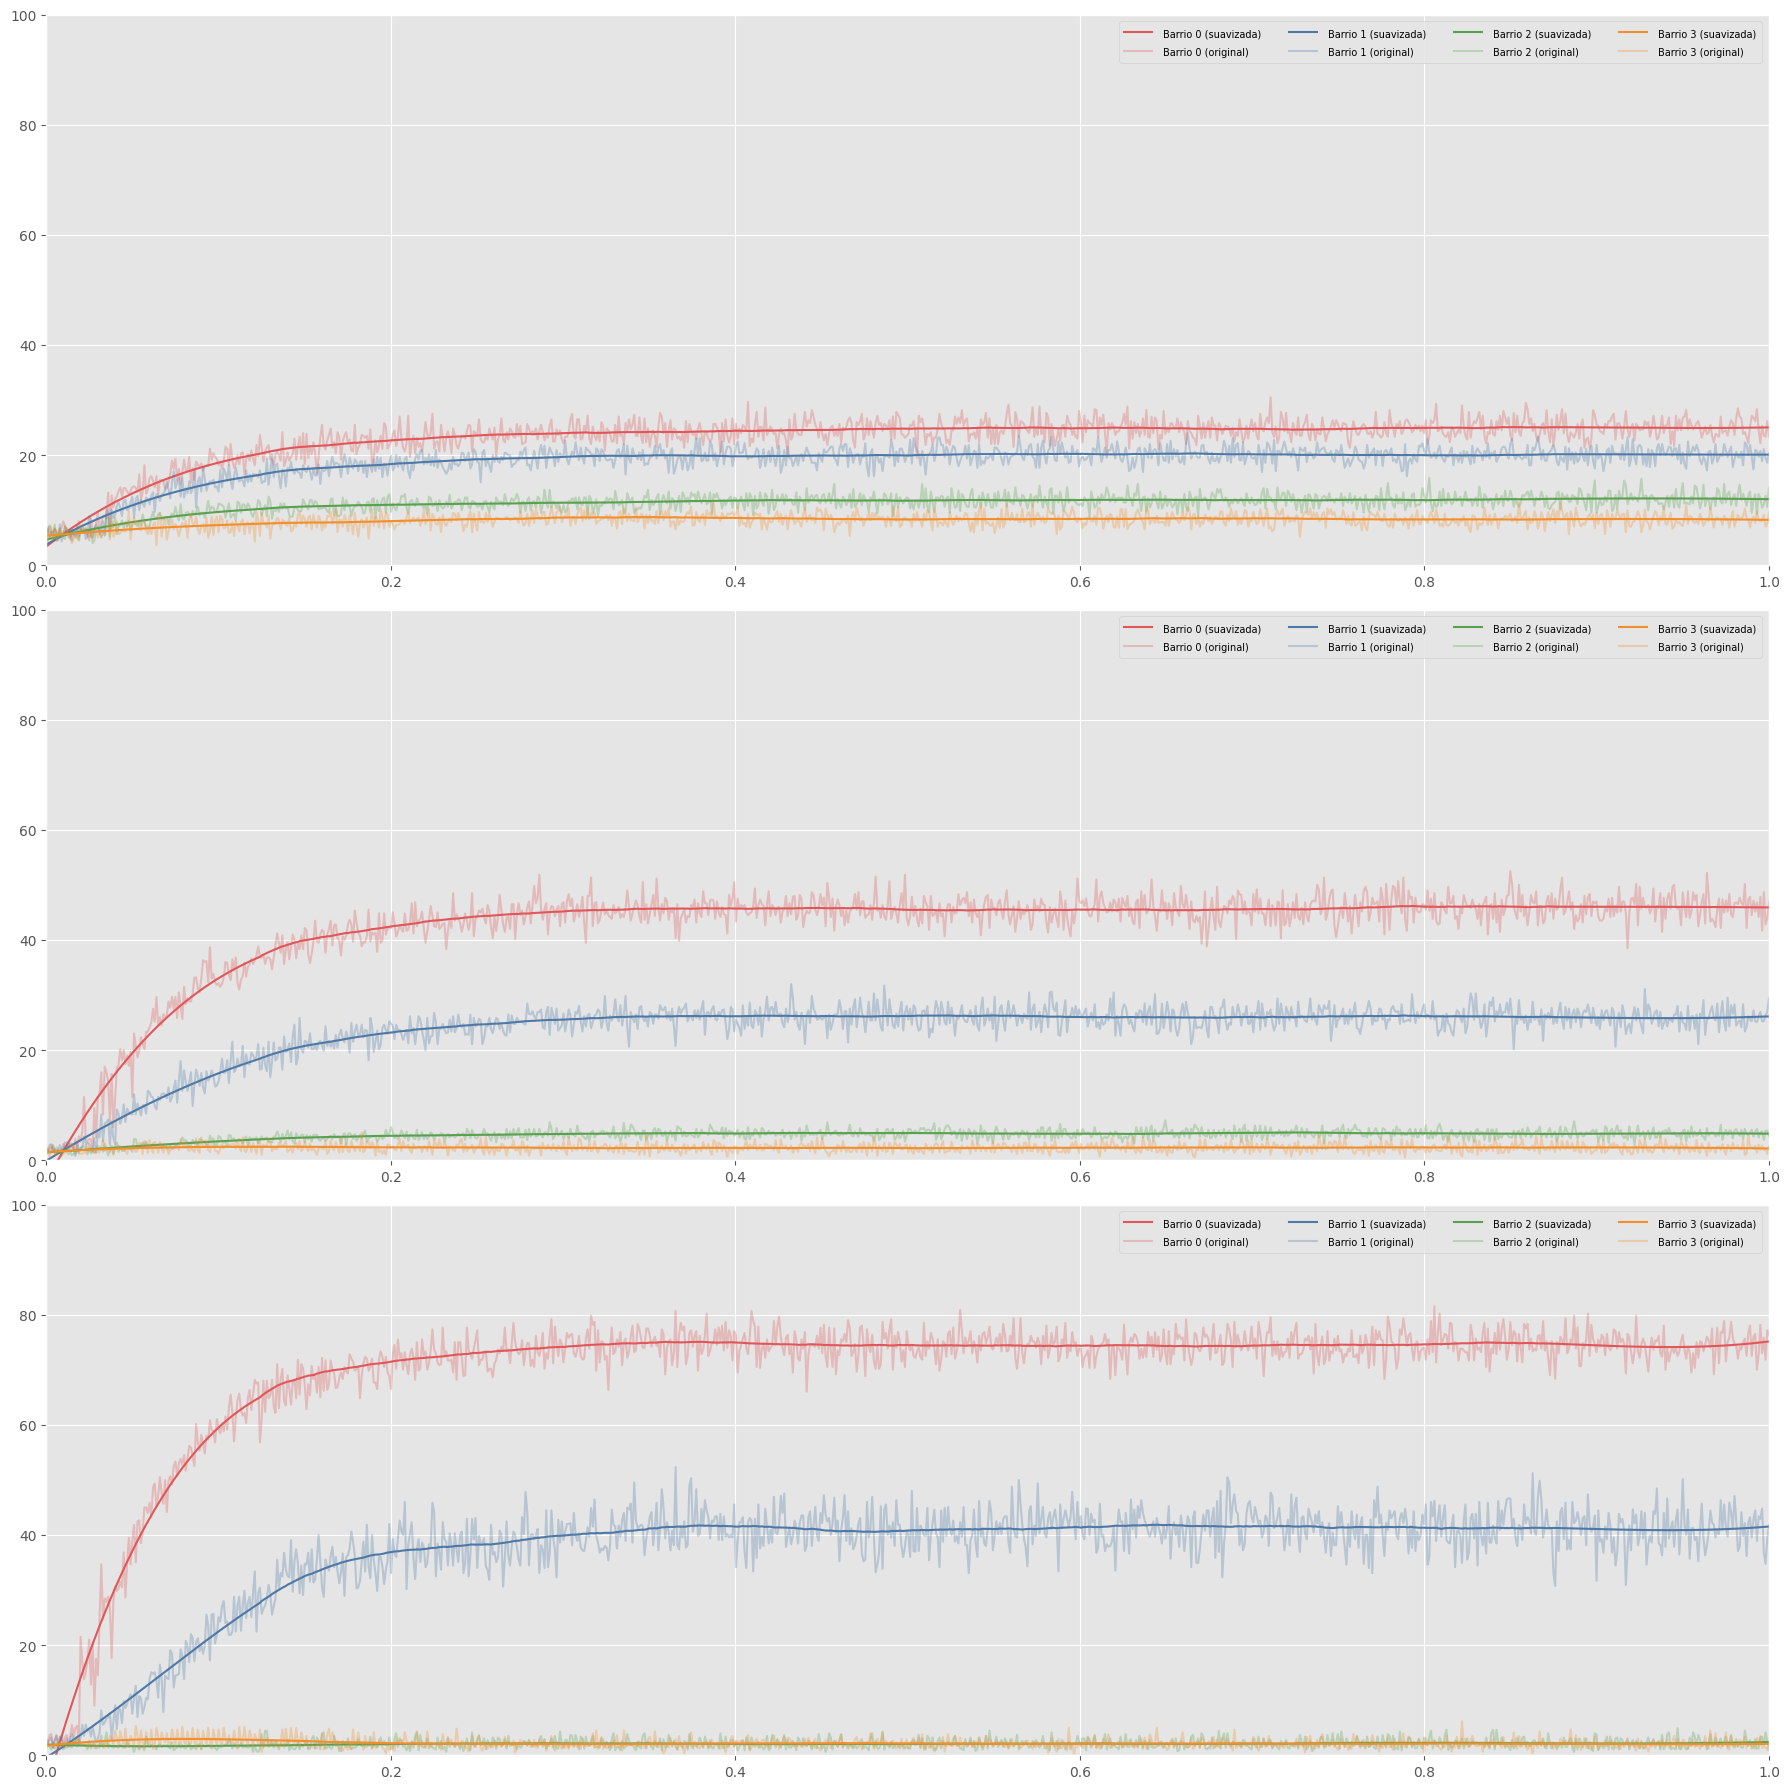

In [36]:
fig, axs = plt.subplots(3, 1, figsize=(18, 18))  
sat = satisfaccion(resultados_2)

plot_satisfacciones_para_alpha(.8, sat, habitantes_por_barrio_cuad, cuatro_cuadrantes.barrios_definidos, ax=axs[0])
plot_satisfacciones_para_alpha(.4, sat, habitantes_por_barrio_cuad, cuatro_cuadrantes.barrios_definidos, ax=axs[1])
plot_satisfacciones_para_alpha(.1, sat, habitantes_por_barrio_cuad, cuatro_cuadrantes.barrios_definidos, ax=axs[2])

plt.tight_layout()
plt.show()

In [37]:
habitantes_por_barrio_tercios = [
    (tercios.mapa == i).sum()
    for i in range(4)
]

#### Mapa tercios y capital inicial máximo 10

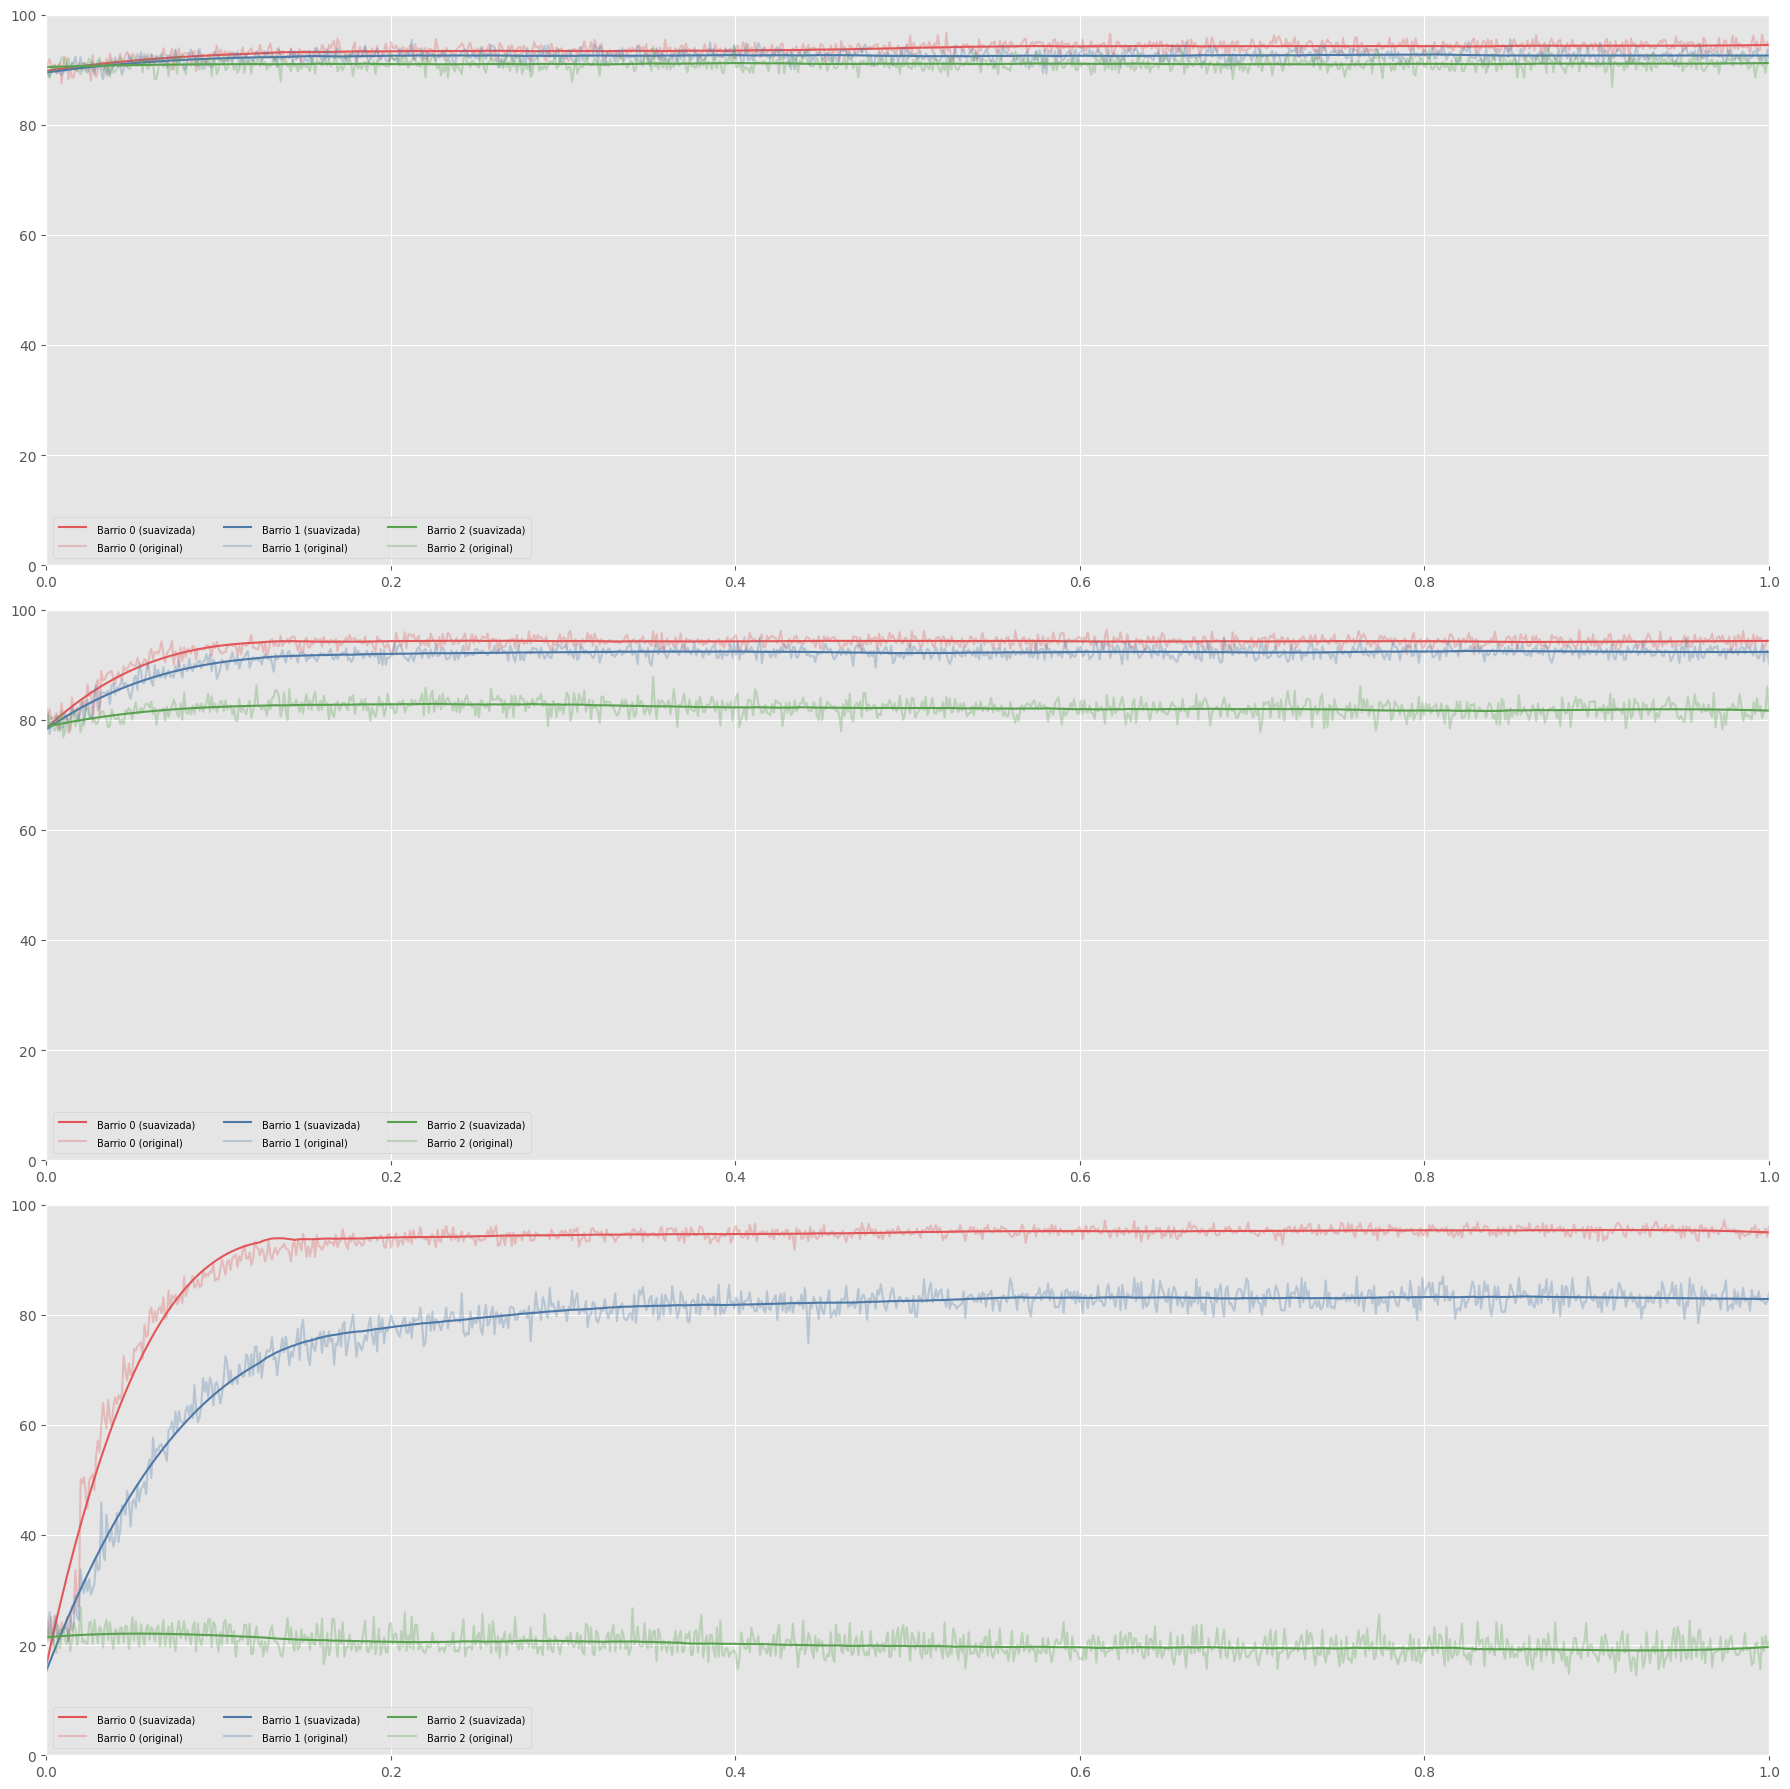

In [38]:
fig, axs = plt.subplots(3, 1, figsize=(18, 18))  
sat = satisfaccion(resultados_3)

plot_satisfacciones_para_alpha(.8, sat, habitantes_por_barrio_tercios[0:3], tercios.barrios_definidos, ax=axs[0])
plot_satisfacciones_para_alpha(.4, sat, habitantes_por_barrio_tercios[0:3], tercios.barrios_definidos, ax=axs[1])
plot_satisfacciones_para_alpha(.1, sat, habitantes_por_barrio_tercios[0:3], tercios.barrios_definidos, ax=axs[2])

plt.tight_layout()
plt.show()

#### Mapa tercios y capital inicial máximo 1

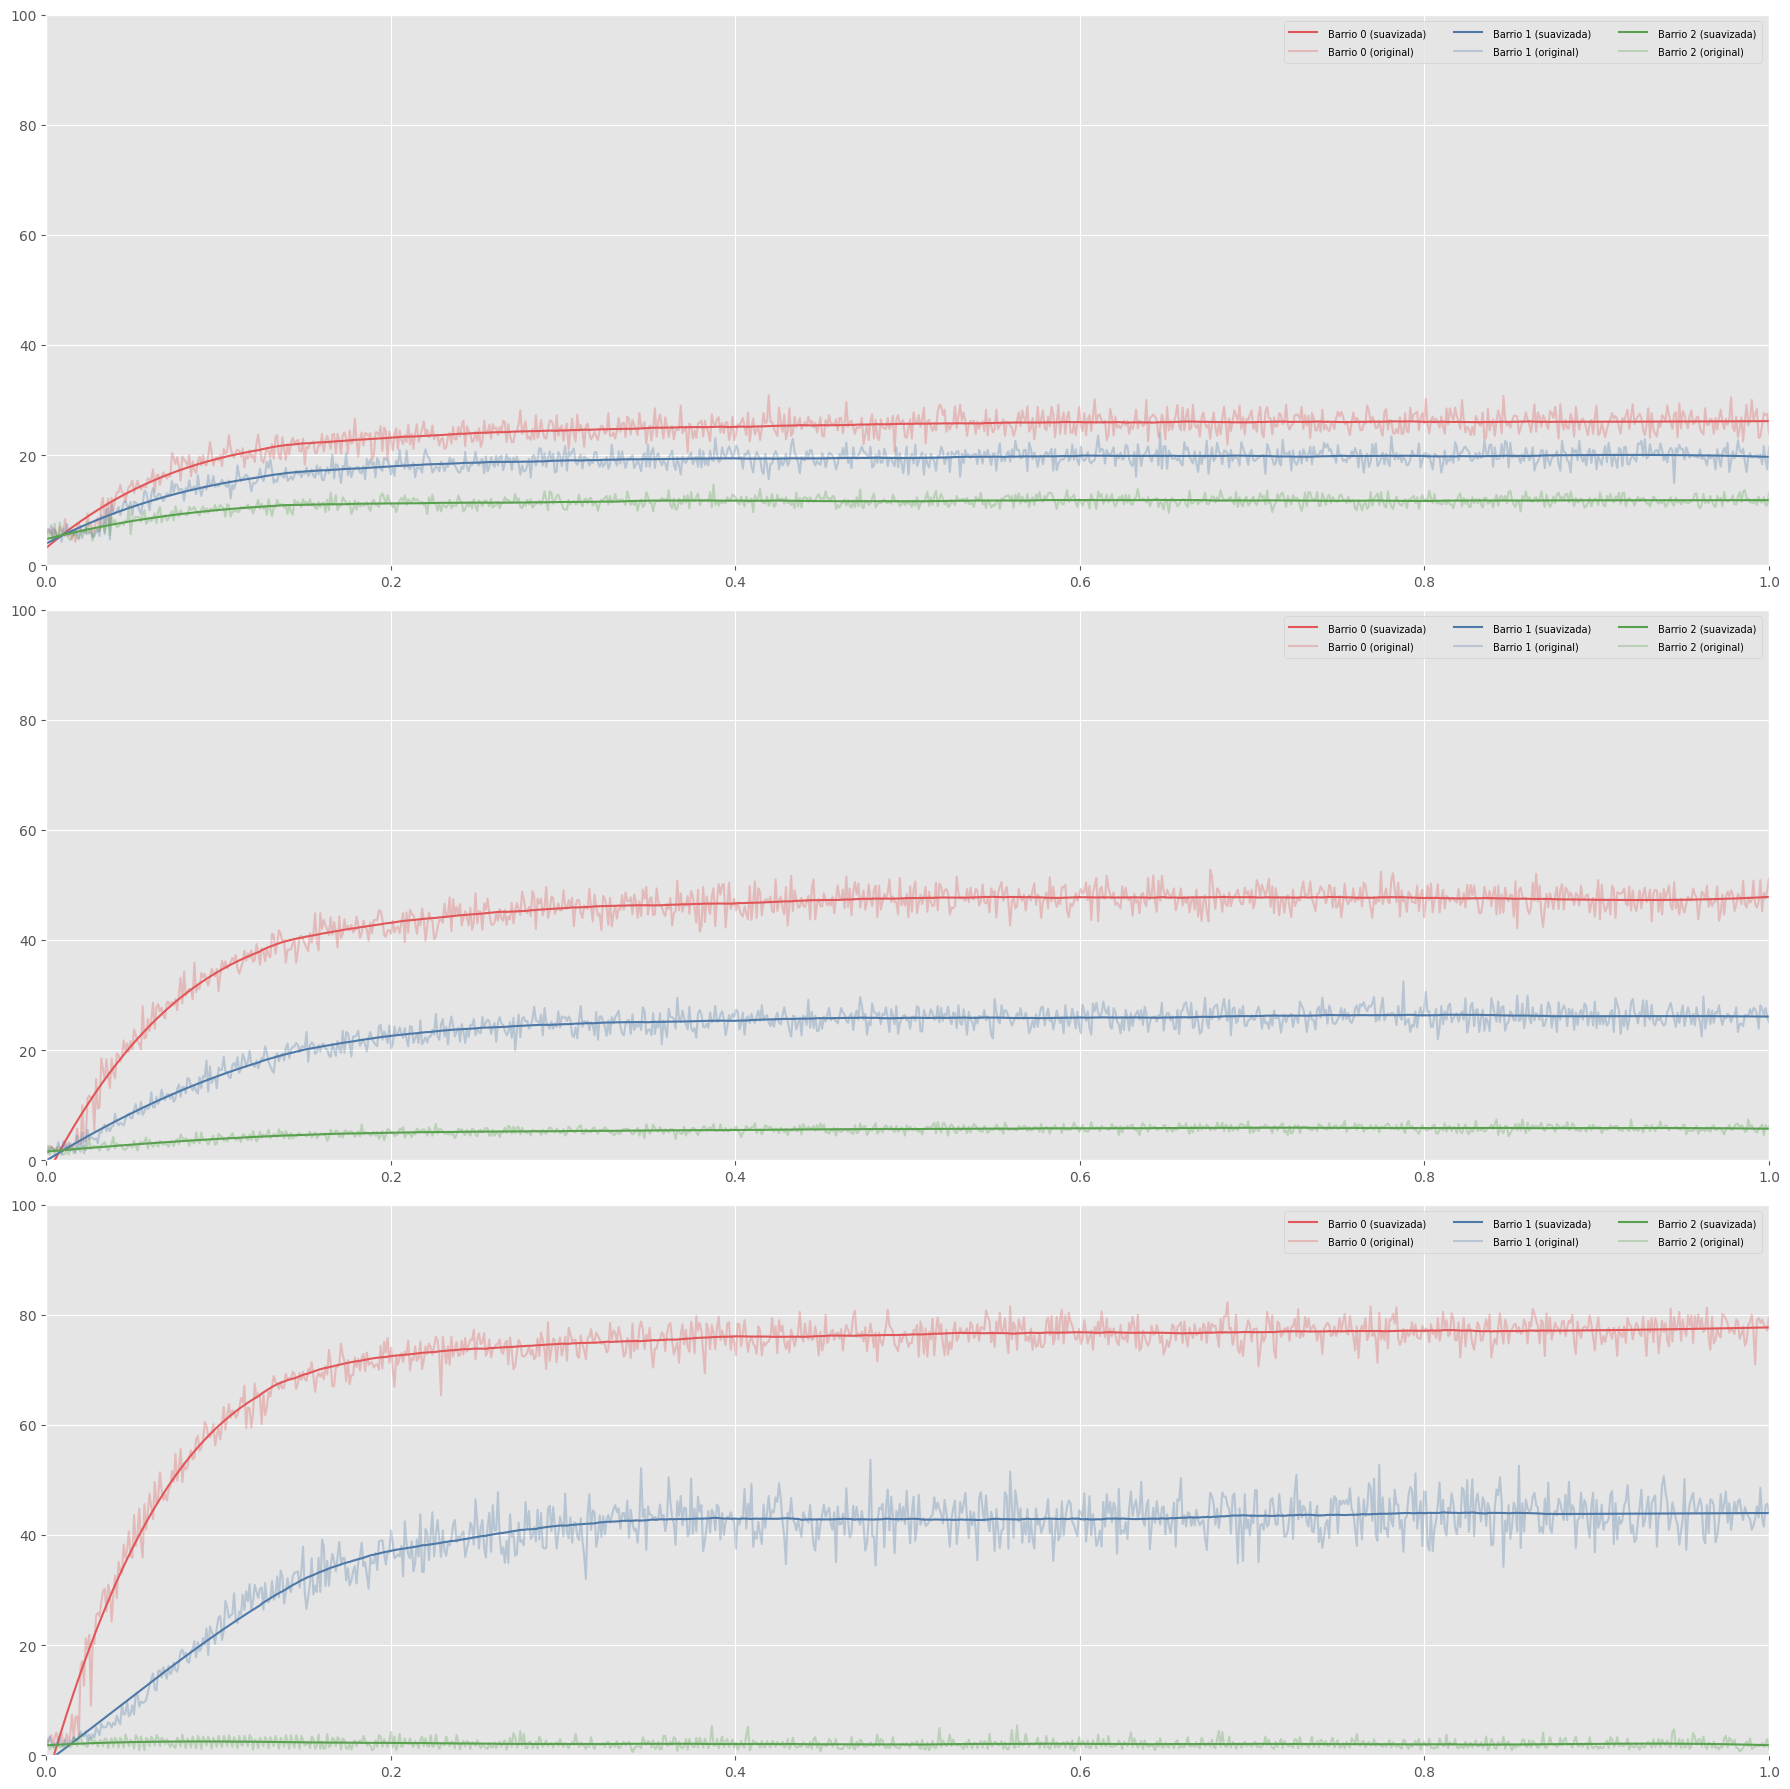

In [39]:
fig, axs = plt.subplots(3, 1, figsize=(18, 18))  
sat = satisfaccion(resultados_4)

plot_satisfacciones_para_alpha(.8, sat, habitantes_por_barrio_tercios[0:3], tercios.barrios_definidos, ax=axs[0])
plot_satisfacciones_para_alpha(.4, sat, habitantes_por_barrio_tercios[0:3], tercios.barrios_definidos, ax=axs[1])
plot_satisfacciones_para_alpha(.1, sat, habitantes_por_barrio_tercios[0:3], tercios.barrios_definidos, ax=axs[2])

plt.tight_layout()
plt.show()

Vemos resultados muy similares a lo visto para mapa de cuadrantes y capital inicial máximo 10.

### C. Pasos hasta estabilizarse

Nos pareció interesante analizar la cantidad de pasos que pasan hasta que el sistema se estabiliza, si es que esto sucede, según la grilla de barrios que se utiliza.

In [40]:
def extraer_mediciones_totales(resultados: dict, key: str):
    mediciones = dict()
    for r in resultados:
        alpha = r['alpha']
        rango = r['rango']

        mediciones.setdefault(alpha, {}).setdefault(rango, r[key])
    
    return mediciones

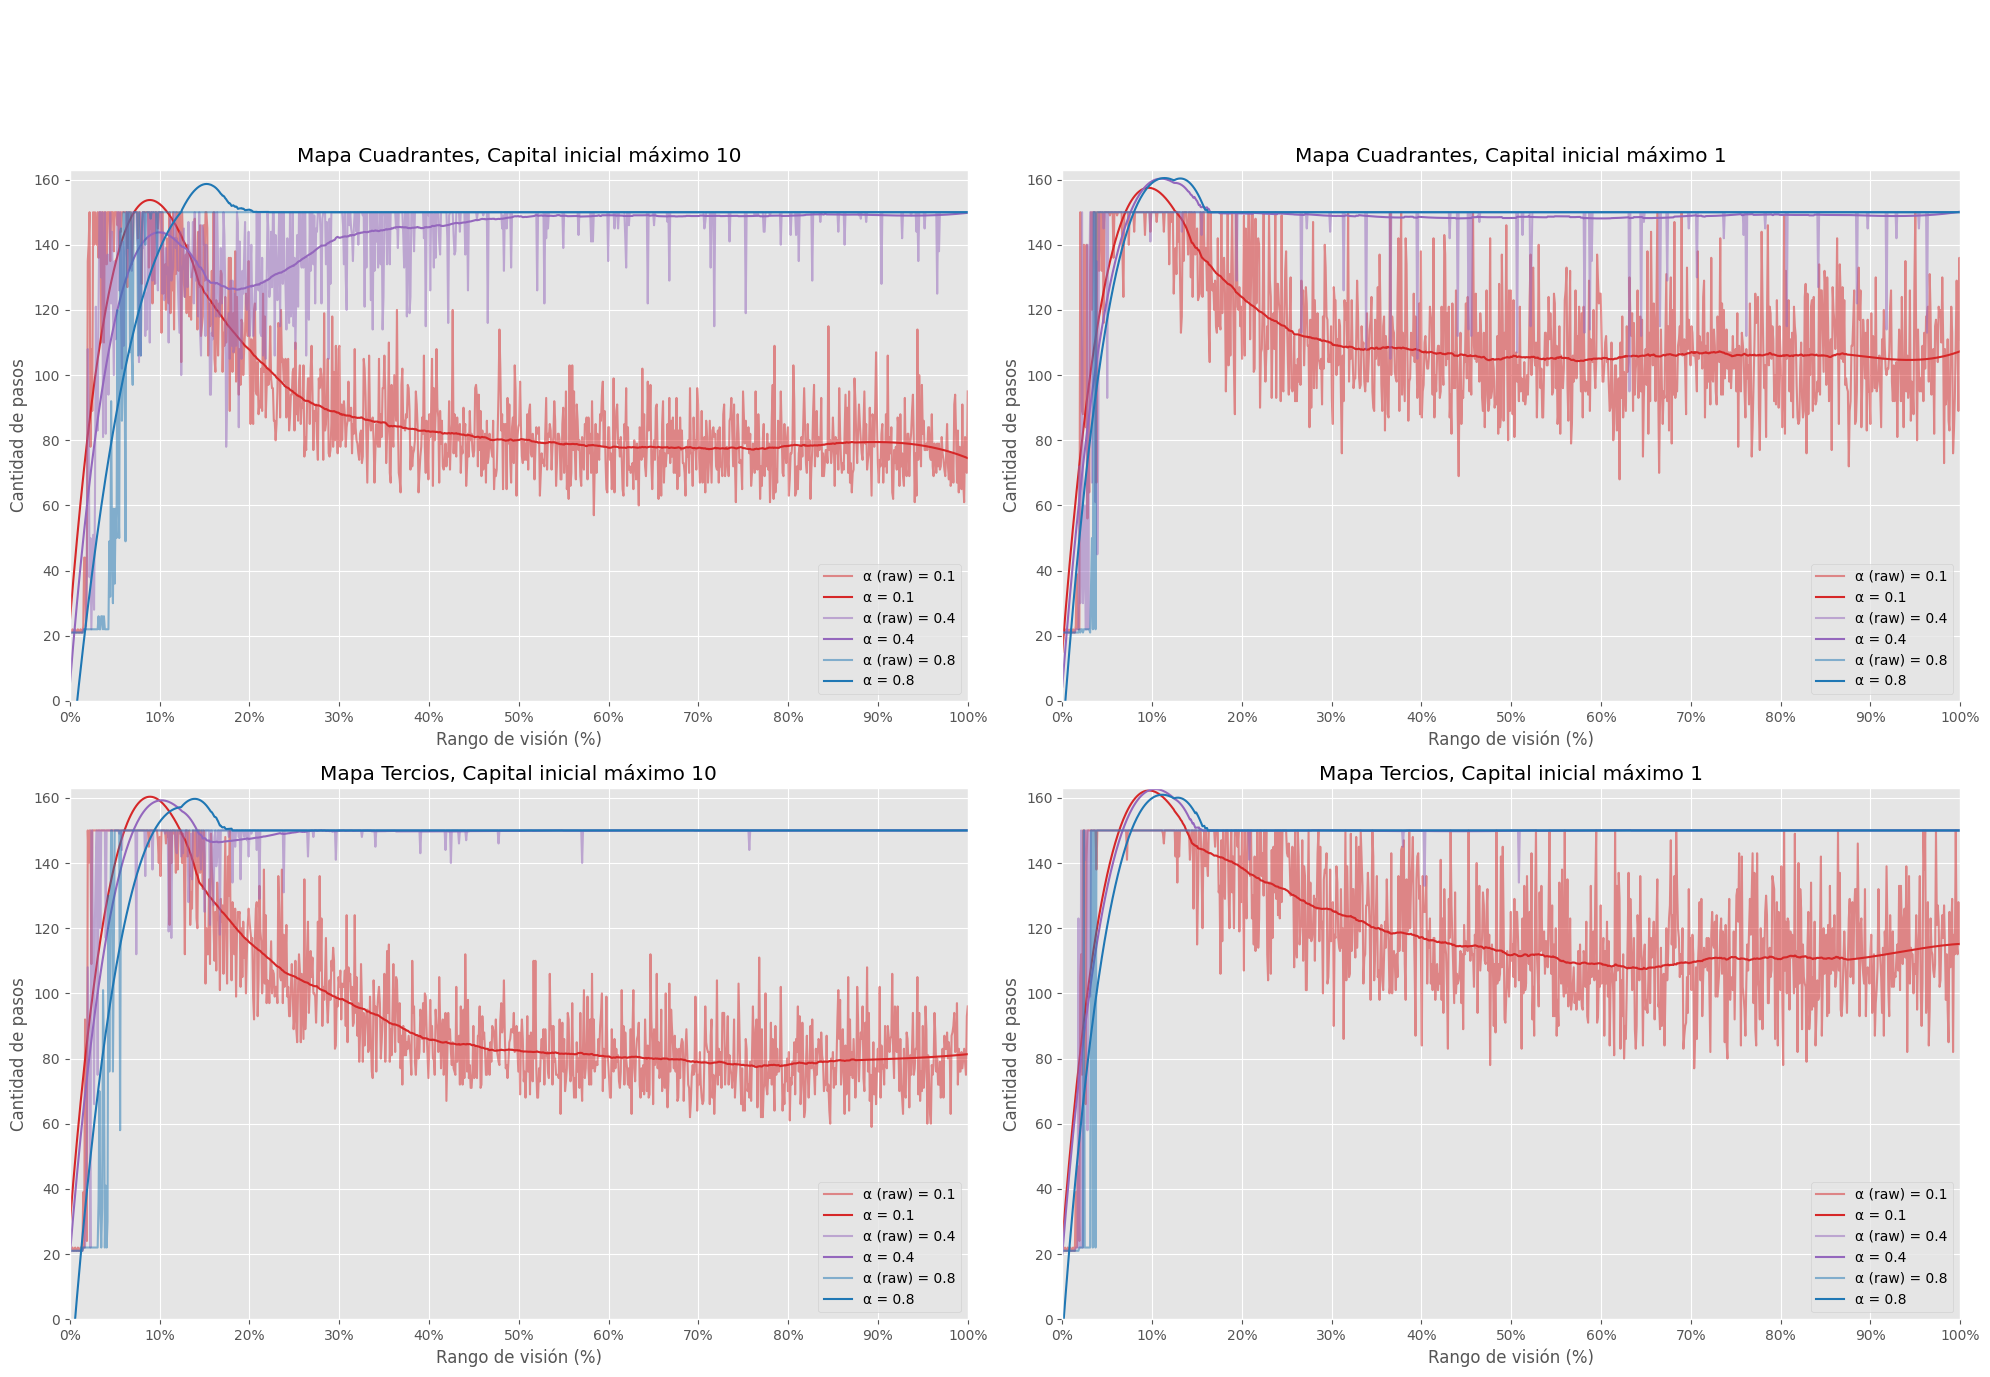

In [41]:
df1 = pd.DataFrame(extraer_mediciones_totales(resultados_1, 'pasos'))
df2 = pd.DataFrame(extraer_mediciones_totales(resultados_2, 'pasos'))
df3 = pd.DataFrame(extraer_mediciones_totales(resultados_3, 'pasos'))
df4 = pd.DataFrame(extraer_mediciones_totales(resultados_4, 'pasos'))

# Colores según alfa
colors = {
    0.1: 'tab:red',
    0.4: 'tab:purple',
    0.8: 'tab:blue'
}

# Crear la figura y los ejes para los cuatro gráficos
fig, axes = plt.subplots(2, 2, figsize=(20, 14))  

# Título principal
fig.suptitle('Pasos hasta estabilizarse en función del rango de visión', fontsize=16)

# Texto adicional explicativo
plt.figtext(0.5, 0.93, 'Resultado de medir la duración (en pasos) de la simulación para 1000 rangos de visión entre 0 y 1 (eje x). \n Limitamos la cantidad de pasos para estabilizarse a 150 pasos.', ha='center', fontsize=12)

# Configuración de los ejes individualmente para cada gráfico
for i, df, title in zip(range(4), [df1, df2, df3, df4], ['Mapa Cuadrantes, Capital inicial máximo 10', 'Mapa Cuadrantes, Capital inicial máximo 1', 'Mapa Tercios, Capital inicial máximo 10', 'Mapa Tercios, Capital inicial máximo 1']):

    # Determinar qué subplot utilizar
    ax = axes[i // 2, i % 2]
    
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 163)
    ax.set_title(title, color='black')  # Título personalizado según el gráfico
    ax.set_xlabel('Rango de visión (%)')
    ax.set_ylabel('Cantidad de pasos')
    ax.set_xticks([i/10 for i in range(11)])
    ax.set_xticklabels([f'{i*10}%' for i in range(11)])

    for alpha in df.columns:
        ax.plot(df.index, df[alpha], alpha=0.5, color=colors[alpha], label=f'α (raw) = {alpha}')
        ax.plot(df.index, smooth_data(df[alpha]), alpha=1, color=colors[alpha], label=f'α = {alpha}')

    legend = ax.legend(loc='lower right')
    # color text to black
    for text in legend.get_texts():
        text.set_color('black')

plt.tight_layout(rect=[0, 0, 1, 0.92])  # Ajustar el layout para hacer espacio al subtítulo
plt.show()


La cantidad de pasos para estas simulaciones está limitada a 150, sin embargo, el proceso que utilizamos para filtrar el ruido y analizar las tendencias de los gráficos generó un overshoot en estos casos: los valores que estén por encima a 150 no son reales, y por tanto un error de la aproximación.

Se puede observar que para el $\alpha$ = 0.1, el problema para estabilizarse está cuando el rango de visión es chico, rondando en un 10%. 

Por otro lado, para el $\alpha$ = 0.8 cuando el capital inicial máximo es 10, vemos que este no se estabiliza desde un rango de visión del 20%. Para el $\alpha$ = 0.4 pasa algo similar pero en menor medida.

Por último, vemos que en el caso del capital inicial máximo 1 para los tres $\alpha$ se llega a una estabilidad desde un rango de visión mayor al 15%.

---